# The Thera Bank - credit card users churn prediction - feature selection, model selection and tuning

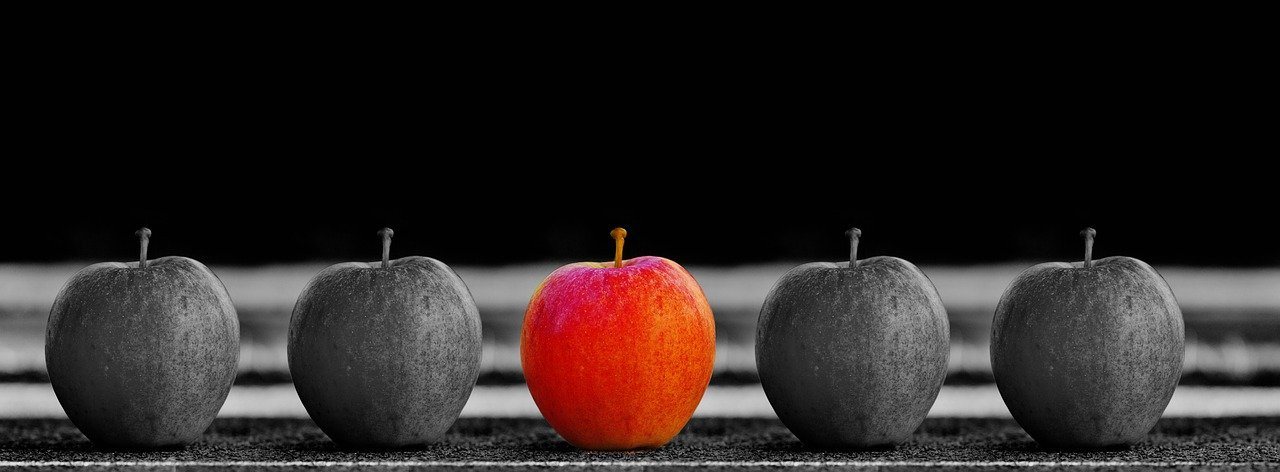

## Context:

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas.

## Objective:
1. Explore and visualize the dataset.
2. Build a classification model to predict if the customer is going to churn or not.
3. Optimize the model using appropriate techniques.
4. Generate a set of insights and recommendations that will help the bank.

## Data Dictionary:
1. CLIENTNUM: Client number. Unique identifier for the customer holding the account
2. Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
3. Customer_Age: Age in Years
4. Gender: Gender of the account holder
5. Dependent_count: Number of dependents
6. Education_Level:  Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.
7. Marital_Status: Marital Status of the account holder
8. Income_Category: Annual Income Category of the account holder
9. Card_Category: Type of Card
10. Months_on_book: Period of relationship with the bank
11. Total_Relationship_Count: Total no. of products held by the customer
12. Months_Inactive_12_mon: No. of months inactive in the last 12 months
13. Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months
14. Credit_Limit: Credit Limit on the Credit Card
15. Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
16. Avg_Open_To_Buy: Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)
17. Total_Trans_Amt: Total Transaction Amount (Last 12 months)
18. Total_Trans_Ct: Total Transaction Count (Last 12 months)
19. Total_Ct_Chng_Q4_Q1: Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
20. Total_Amt_Chng_Q4_Q1: Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
21. Avg_Utilization_Ratio: Represents how much of the available credit the customer spent

### Import required libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)

#load_ext nb_black

# library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")

# libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# library to split data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from sklearn import metrics

# library to build Linear Regression Model
from sklearn.linear_model import LogisticRegression

# library to encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# libraries to build ensemble models
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# libraries to build xgboost model
from xgboost import XGBClassifier

# library for stacking classifier
from sklearn.ensemble import StackingClassifier

# to tune different models
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV

# to get diferent metric scores
from sklearn.metrics import (
    recall_score,
    confusion_matrix,
)

# for oversampling and undersampling data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# for missing value imputation
from sklearn.impute import SimpleImputer

## Define all required functions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# histogram and boxplot for the feature
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="orange"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="Winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="blue", linestyle="-")
    plt.show()  # show the plot

# labeled_barplot
def labeled_barplot(data, feature, perc=False, v_ticks=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    if v_ticks is True:
        plt.xticks(rotation=90)

    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.show()  # show the plot

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# to plot confusion matrix
def draw_matrix(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# calculate different metric scores of the model - Accuracy, Recall, F1 and Precision
def get_metrics_score(model,flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store results
    score_list=[]
    accuracy_list=[]
    precision_list=[]
    recall_list=[]
    f1_list=[]

    # predicting on train and tests
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # accuracy of the model
    train_acc = model.score(X_train,y_train)
    val_acc = model.score(X_val,y_val)
    test_acc = model.score(X_test,y_test)

    # recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    val_recall = metrics.recall_score(y_val,pred_val)
    test_recall = metrics.recall_score(y_test,pred_test)

    # precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    val_precision = metrics.precision_score(y_val,pred_val)
    test_precision = metrics.precision_score(y_test,pred_test)

    # f1_score of the model
    train_f1 = metrics.f1_score(y_train,pred_train)
    val_f1 = metrics.f1_score(y_val,pred_val)
    test_f1 = metrics.f1_score(y_test,pred_test)

    # populate the score_list
    score_list.extend((train_acc,val_acc,test_acc,train_recall,val_recall,test_recall,train_precision,
                        val_precision,test_precision,train_f1,val_f1,test_f1))

    #list per data set
    accuracy_list.extend((train_acc,val_acc,test_acc))
    recall_list.extend((train_recall,val_recall,test_recall))
    precision_list.extend((train_precision,val_precision,test_precision))
    f1_list.extend((train_f1,val_f1,test_f1))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:

        print("Accuracy on training set : ",train_acc)
        print("Accuracy on validation set : ",val_acc)
        print("Accuracy on test set : ",test_acc)
        print("Recall on training set : ",train_recall)
        print("Recall on validation set : ",val_recall)
        print("Recall on test set : ",test_recall)
        print("Precision on training set : ",train_precision)
        print("Precision on validation set : ",val_precision)
        print("Precision on test set : ",test_precision)
        print("F1 on training set : ",train_f1)
        print("F1 on validation set : ",val_f1)
        print("F1 on test set : ",test_f1)

    model_df = pd.DataFrame({"DataSet":["Training", "Validation", "Testing"],
                                          "Accuracy": accuracy_list, "Recall": recall_list,
                                          "Precision": precision_list,"F1": f1_list})

    return model_df, score_list  # returning the list with train and test scores

## Load the dataset

In [4]:
# load the file using excel. There are two sheets in the excel. Load the Tourism sheet
df = pd.read_csv('/content/drive/My Drive/project/BankChurners.csv')

# back up data to preserve the initial version for reference
df_back = df.copy()

## Understand the data

### Shape of data

In [5]:
# print the data set information as number of rows and columns
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")  # f-string

There are 10127 rows and 21 columns.


### Dataset information

In [6]:
# check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

**Observations:**
1. There are 21 columns in the dataset.
2. Education_Level, Marital_Status columns have less than 10127 values, indicating existance of NULL Values.
3. All categorical columns are of object type and can be used for onehot encoding.

### Sample data

In [7]:
# setting the random seed via np.random.seed to get the same random results every time
np.random.seed(1)

# also look at random 10 sample rows
df.sample(n=10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
6498,712389108,Existing Customer,43,F,2,Graduate,Married,Less than $40K,Blue,36,6,3,2,2570.0,2107,463.0,0.651,4058,83,0.766,0.820
9013,718388733,Existing Customer,38,F,1,College,NaN,Less than $40K,Blue,32,2,3,3,2609.0,1259,1350.0,0.871,8677,96,0.627,0.483
2053,710109633,Existing Customer,39,M,2,College,Married,$60K - $80K,Blue,31,6,3,2,9871.0,1061,8810.0,0.545,1683,34,0.478,0.107
3211,717331758,Existing Customer,44,M,4,Graduate,Married,$120K +,Blue,32,6,3,4,34516.0,2517,31999.0,0.765,4228,83,0.596,0.073
5559,709460883,Attrited Customer,38,F,2,Doctorate,Married,Less than $40K,Blue,28,5,2,4,1614.0,0,1614.0,0.609,2437,46,0.438,0.000
6106,789105183,Existing Customer,54,M,3,Post-Graduate,Single,$80K - $120K,Silver,42,3,1,2,34516.0,2488,32028.0,0.552,4401,87,0.776,0.072
4150,771342183,Attrited Customer,53,F,3,Graduate,Single,$40K - $60K,Blue,40,6,3,2,1625.0,0,1625.0,0.689,2314,43,0.433,0.000
2205,708174708,Existing Customer,38,M,4,Graduate,Married,$40K - $60K,Blue,27,6,2,4,5535.0,1276,4259.0,0.636,1764,38,0.900,0.231
4145,718076733,Existing Customer,43,M,1,Graduate,Single,$60K - $80K,Silver,31,4,3,3,25824.0,1170,24654.0,0.684,3101,73,0.780,0.045
5324,821889858,Attrited Customer,50,F,1,Doctorate,Single,abc,Blue,46,6,4,3,1970.0,1477,493.0,0.662,2493,44,0.571,0.750


**Observations:**

1. CLIENTNUM being customer identifier will not add value to our model building and can be dropped during dependent variable spilt.
2. Attrition_Flag is our target column, we will have encode the values before model building.
3. Income_Category column needs to be reviewed and feature engineering if required can be done on the column.


### Check the null values

In [8]:
# number of missing values in columns
df.isna().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [9]:
# precentage of missing values in columns
round(df.isna().sum() / df.isna().count() * 100, 2)

CLIENTNUM                    0.0
Attrition_Flag               0.0
Customer_Age                 0.0
Gender                       0.0
Dependent_count              0.0
Education_Level             15.0
Marital_Status               7.4
Income_Category              0.0
Card_Category                0.0
Months_on_book               0.0
Total_Relationship_Count     0.0
Months_Inactive_12_mon       0.0
Contacts_Count_12_mon        0.0
Credit_Limit                 0.0
Total_Revolving_Bal          0.0
Avg_Open_To_Buy              0.0
Total_Amt_Chng_Q4_Q1         0.0
Total_Trans_Amt              0.0
Total_Trans_Ct               0.0
Total_Ct_Chng_Q4_Q1          0.0
Avg_Utilization_Ratio        0.0
dtype: float64

**Observations:**
1. Education_Level has 15% (1519) missing values.
2. Marital_Status has 7.4% (749) missing values.

### Check the duplicated values

In [10]:
# let"s check for duplicate values in the data
df.duplicated().sum()

0

**Observations:**

There are no duplicated values.

### Check the basic statistics

In [11]:
# let"s view the statistical summary of the numerical columns in the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


**Observations:**

1. The features are on different scales, for instance Months_on_book has 13 as minimum and Credit_Limit has 1438.
2. CLIENTNUM has high uniform values on all scales as it customer identifier.
3. For most variables mean is higher than standard deviation, depicting right sckewed data.

### Check the distinct values for anomalies

In [12]:
# create numerical columns list
num_cols = df.select_dtypes(include=["int64", "float64"])

# create categorical columns list
cat_cols = df.select_dtypes(exclude=["int64", "float64"])

In [13]:
#get the valuecounts
for i in cat_cols:
    print(df[i].value_counts())
    print("-"*50)
    print("\n")

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
--------------------------------------------------


F    5358
M    4769
Name: Gender, dtype: int64
--------------------------------------------------


Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
--------------------------------------------------


Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64
--------------------------------------------------


Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
--------------------------------------------------


Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64
--------------------------------------------------




**Observations:**
1. Income_Category has 1112 records with "abc", we will have to correct this.
2. Gender, Education_Level, Marital_Status and Card_Category columns doesn"t show any anomaly.

## Data pre-processing

### Impute null values for Marital_Status

Education_Level, Income_Category and Card_Category can be checked for influence on Marital_Status

In [14]:
df[df["Marital_Status"].isna()]["Card_Category"].value_counts()

Blue        683
Silver       52
Gold         12
Platinum      2
Name: Card_Category, dtype: int64

In [15]:
df[df["Card_Category"] == "Blue"]["Marital_Status"].value_counts()

Married     4433
Single      3624
Divorced     696
Name: Marital_Status, dtype: int64

In [16]:
df[df["Marital_Status"].isna()]["Income_Category"].value_counts()

Less than $40K    250
$80K - $120K      136
$40K - $60K       132
$60K - $80K       102
abc                82
$120K +            47
Name: Income_Category, dtype: int64

In [17]:
df[df["Income_Category"] == "Less than $40K"]["Marital_Status"].value_counts()

Married     1628
Single      1429
Divorced     254
Name: Marital_Status, dtype: int64

In [18]:
df[df["Marital_Status"].isna()]["Education_Level"].value_counts()

Graduate         227
High School      154
Uneducated       109
College           74
Post-Graduate     43
Doctorate         28
Name: Education_Level, dtype: int64

**Observations:**

1. We have cross validated missing value for Marital_Status with other variables like Education_Level, Card_Category and Income_Category.
2. Though the validation shows that most of the customers may be married, but it is not clearly indicated.
3. We will update the missing values using SimpleImputer with strategy as most_frequent.

In [19]:
# use simple imputer to impute the most_frequent values in categorical column
mar_imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
df.Marital_Status = mar_imputer.fit_transform(df["Marital_Status"].values.reshape(-1,1))[:,0]

In [20]:
df["Marital_Status"].value_counts()

Married     5436
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64

**Observations:**

NULL Values are treated.

### Impute null values for Education_Level

Income_Category can be checked for influence on Education_Level

In [21]:
df[df["Education_Level"].isna()]["Income_Category"].value_counts()

Less than $40K    556
$40K - $60K       269
$80K - $120K      219
$60K - $80K       210
abc               145
$120K +           120
Name: Income_Category, dtype: int64

In [22]:
df[df["Income_Category"] == "Less than $40K"]["Education_Level"].value_counts()

Graduate         1139
High School       671
Uneducated        522
College           345
Post-Graduate     170
Doctorate         158
Name: Education_Level, dtype: int64

**Observations:**
1. We see that almost 30% Customers with missing Education_Level are from Income_Category "Less than $40K".
2. and most customers with the Income_Category "Less than $40K" are Graduates.
3. We can assume and update Education_Level to "Graduate", however post that update the data may become biased for one specific category.
4. We will use simple imputer to impute the null values with most_frequent strategy.

In [23]:
# use simple imputer to impute the most_frequent values in categorical column
edu_imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
df.Education_Level = edu_imputer.fit_transform(df["Education_Level"].values.reshape(-1,1))[:,0]

In [24]:
df["Education_Level"].value_counts()

Graduate         4647
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

**Observations:**

NULL Values are treated.

#### Check the null values

In [25]:
# precentage of missing values in columns
round(df.isna().sum() / df.isna().count() * 100, 2)

CLIENTNUM                   0.0
Attrition_Flag              0.0
Customer_Age                0.0
Gender                      0.0
Dependent_count             0.0
Education_Level             0.0
Marital_Status              0.0
Income_Category             0.0
Card_Category               0.0
Months_on_book              0.0
Total_Relationship_Count    0.0
Months_Inactive_12_mon      0.0
Contacts_Count_12_mon       0.0
Credit_Limit                0.0
Total_Revolving_Bal         0.0
Avg_Open_To_Buy             0.0
Total_Amt_Chng_Q4_Q1        0.0
Total_Trans_Amt             0.0
Total_Trans_Ct              0.0
Total_Ct_Chng_Q4_Q1         0.0
Avg_Utilization_Ratio       0.0
dtype: float64

**Observations:**

We see that all null values are now treated

### Process the Income_Category Column

#### Check the distinct data sets

In [26]:
# check value_counts
df.Income_Category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64

#### We understand that Education_Level is a great influencer for Income_Category, let us cross validate

In [27]:
# check Eduation_Level values for income_category abc
df[df["Income_Category"] == "abc"]["Education_Level"].value_counts()

Graduate         477
High School      225
Uneducated       185
College          108
Doctorate         70
Post-Graduate     47
Name: Education_Level, dtype: int64

**Observations:**

1. This is clearly a data input error.
2. We are not able to accertain which category to replace "abc".
3. Since all income categories are covered in the variable, it is clear the NULL Values are represented as "abc" due to data capture.

In [28]:
# treating error
ic_imputer = SimpleImputer(missing_values="abc", strategy="most_frequent")
df.Income_Category = ic_imputer.fit_transform(df["Income_Category"].values.reshape(-1,1))[:,0]

#### Verify the update

In [29]:
# verify the update
df.Income_Category.value_counts()

Less than $40K    4673
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
$120K +            727
Name: Income_Category, dtype: int64

**Observations:**

Income_Category "abc" is now treated and imputed with most_frequent value "Less than $40k"

### Encode the target column

In [30]:
# values before encoding
df.Attrition_Flag.value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [31]:
# instantiate the LabelEncoder
encode_attr = LabelEncoder()

# fit the encoder
encode_attr.fit(df["Attrition_Flag"])

# encode the variable
df["Attrition_Flag"] = encode_attr.transform(df["Attrition_Flag"])

# verify the update
df.Attrition_Flag.value_counts()

1    8500
0    1627
Name: Attrition_Flag, dtype: int64

**Observations:**

The target columne is now encoded with Existing Customers as 1 and Attrited Customers as 0.

## Univariate Analysis

### CLIENTNUM

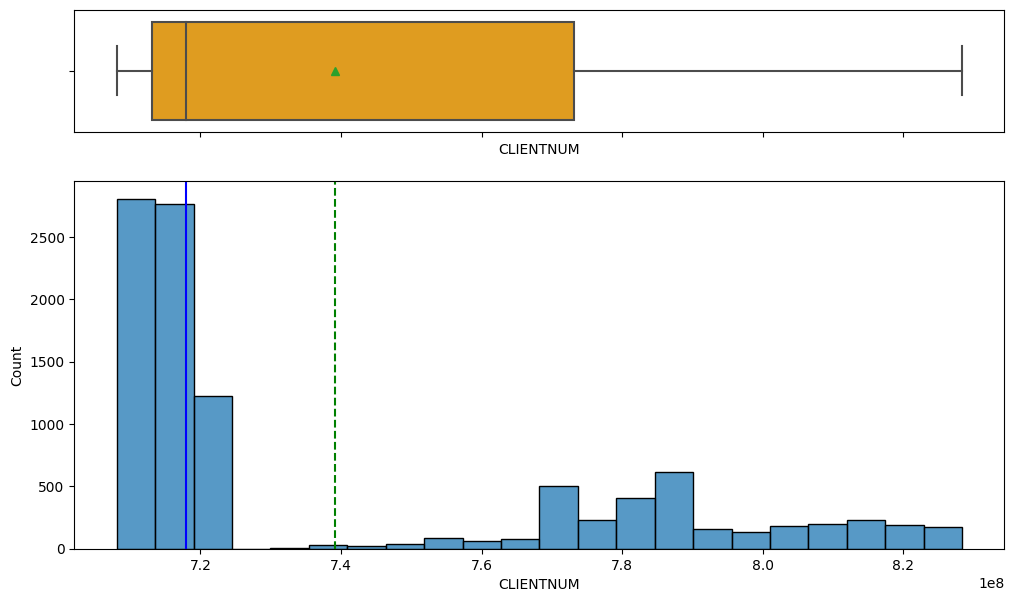

In [32]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"CLIENTNUM")

**Observations:**
1. CLIENTNUM shows uneven distirbution of data and appears to have outliers.
2. CLIENTNUM is customer identifier in the dataset and would not be used in our analysis.
3. No handling required for the variable.

### Attrition_Flag - target variable

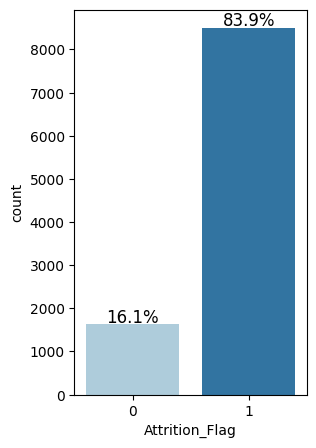

In [33]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Attrition_Flag", True, False)

**Observations:**

Target variable shows 83.9% customers are existing and 16.1% are attrited.

### Customer_Age

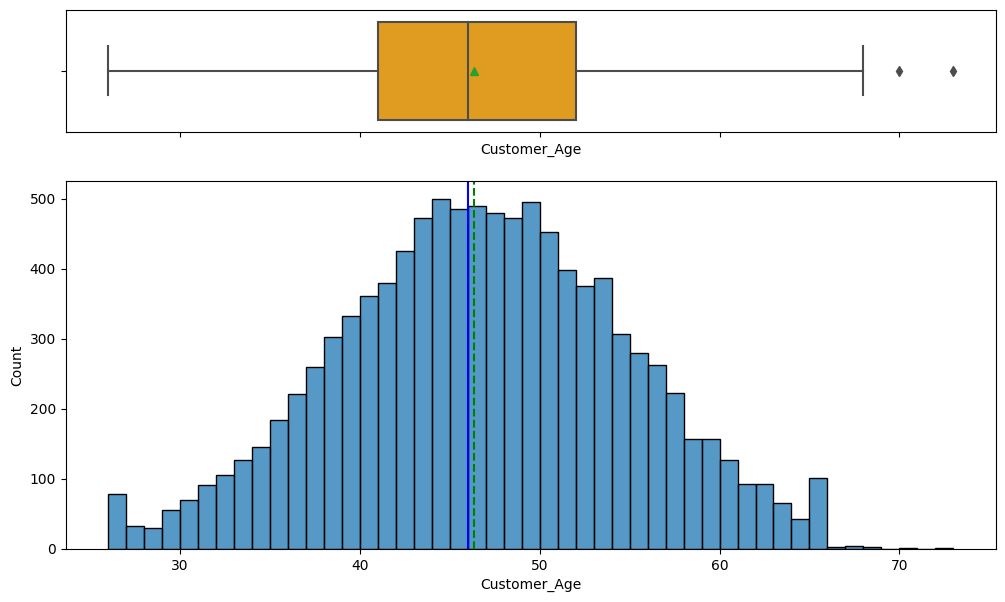

In [34]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Customer_Age")

In [35]:
df.loc[df["Customer_Age"] > 70]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
251,715952883,1,73,M,0,High School,Married,$40K - $60K,Blue,36,5,3,2,4469.0,1125,3344.0,1.363,1765,34,1.615,0.252


**Observations:**
1. Mean is slightly smaller than median.
2. The data looks normally distributed.
3. There is one customer with age of 73 years, it is possible case and is not an outlier.

### Gender

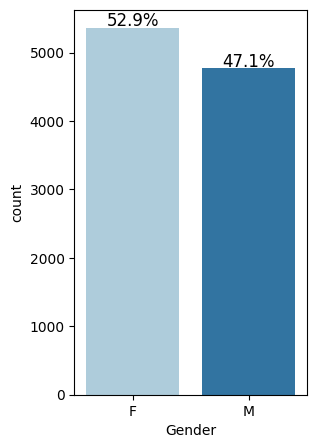

In [36]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Gender", True, False)

**Observations:**

Number of Female customers is higher than Male customers.

### Dependent_count

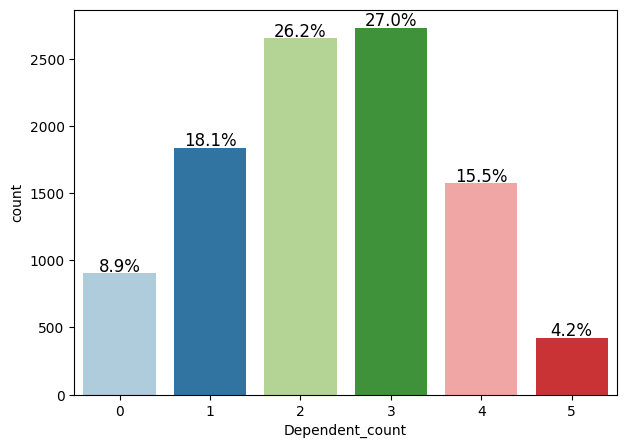

In [37]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Dependent_count", True, False)

**Observations:**

Most customers have 3 dependents followed by customers with 2 and 1 dependents.

### Education_Level

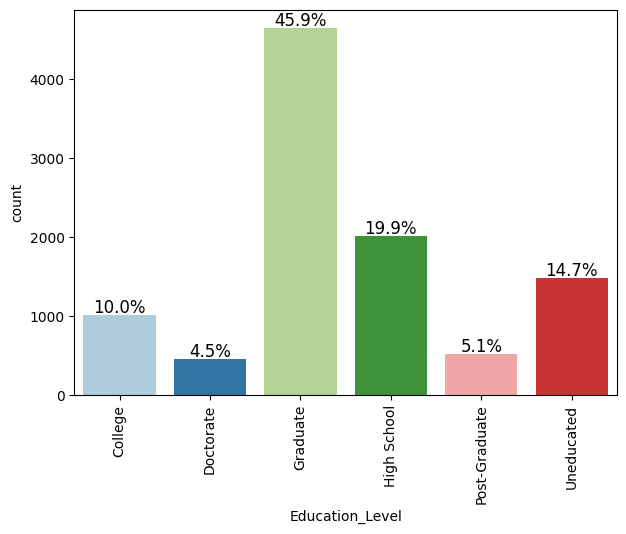

In [38]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Education_Level", True, True)

**Observations:**

Most customers are Graduate followed by High School.

### Marital_Status

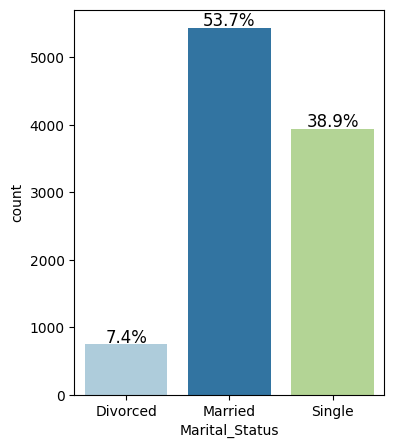

In [39]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Marital_Status", True, False)

**Observations:**
1. Around 53% customers are married.
2. Next highest population is Single customers.

### Income_Category

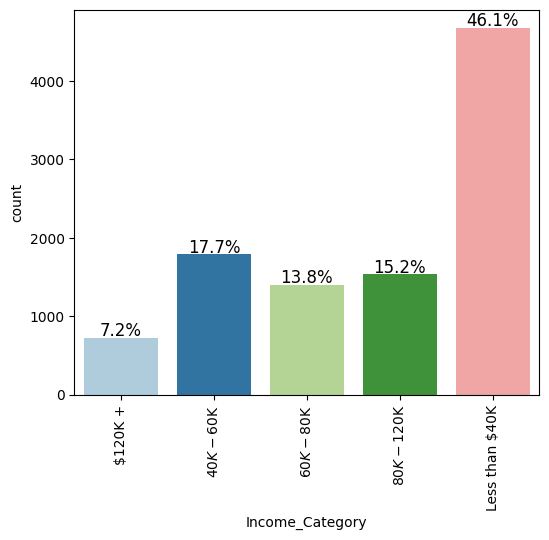

In [40]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Income_Category", True, True)

**Observations:**

1. Most customers earn Less than $40K.
2. Followed by customers earning between $40K to $60K.

### Card_Category

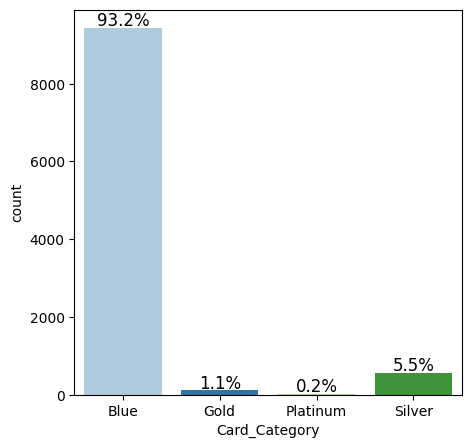

In [41]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Card_Category", True, False)

**Observations:**
1. Most customers in the dataset have "Blue" Card.
2. There are very few customers using "Gold" and "Platinum" Cards.
3. We also see some customers using "Silver" Card.

### Months_on_book

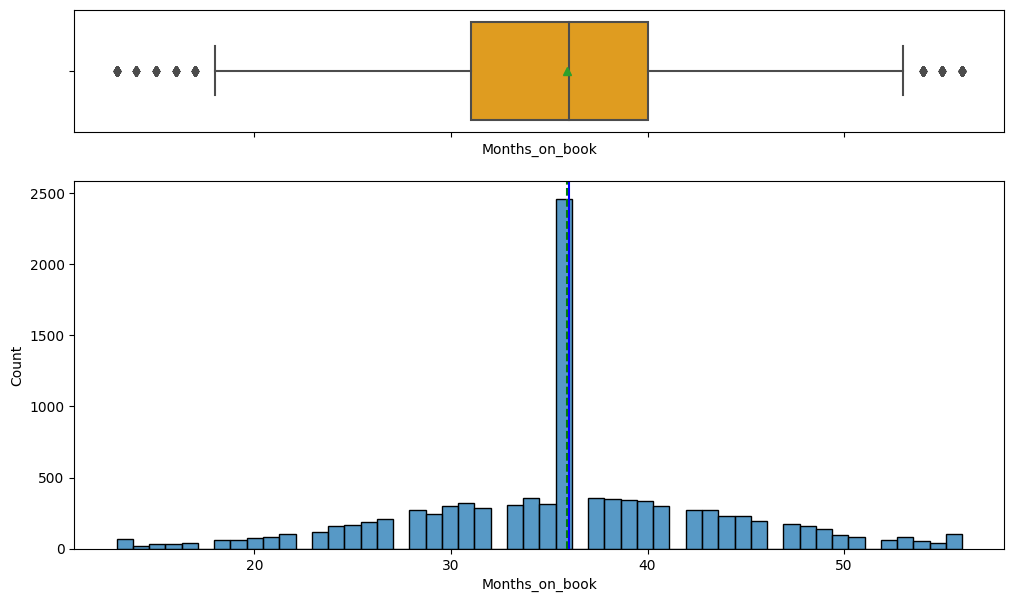

In [42]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Months_on_book")

**Observations:**
1. Mean is almost equal to median and the data looks well distributed on both sides.
2. There are customers who are assocated with bank for almost 5 years.

### Total_Relationship_Count

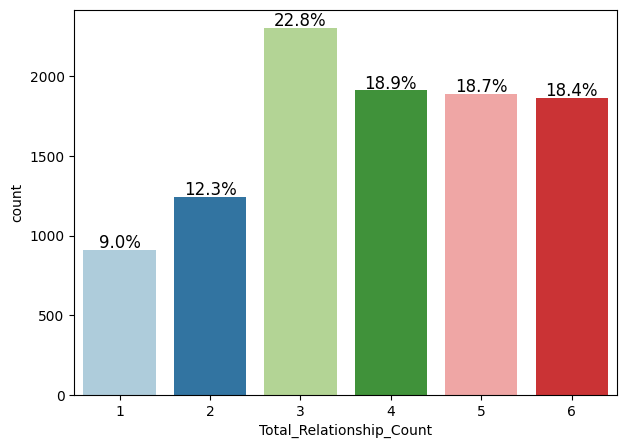

In [43]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Total_Relationship_Count", True, False)

**Observations:**
1. Around 1/4th of customers have 3 relationships with bank.
2. Customers with 4,5 and 6 relationships are almost equal in numbers.

### Months_Inactive_12_mon

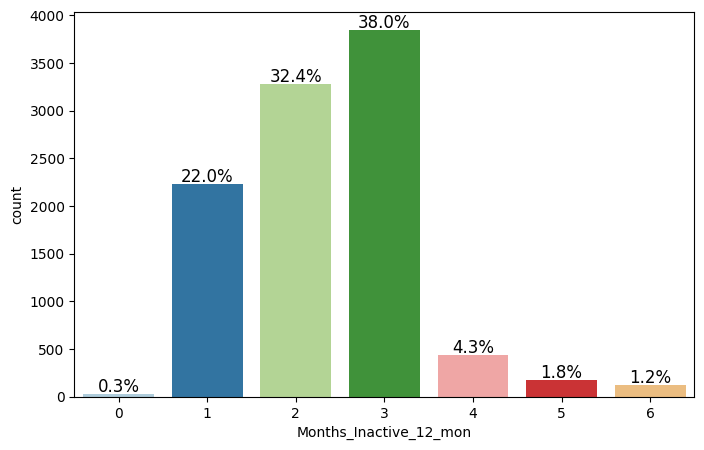

In [44]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Months_Inactive_12_mon", True, False)

**Observations:**
1. 38% of customers have not used the card for 3 months in last 12 months.
2. The data shows that a small fraction of customers are active every month.
3. There are around 1.2% of customers who have not used there cards for 6 months in last 12 months.

### Contacts_Count_12_mon

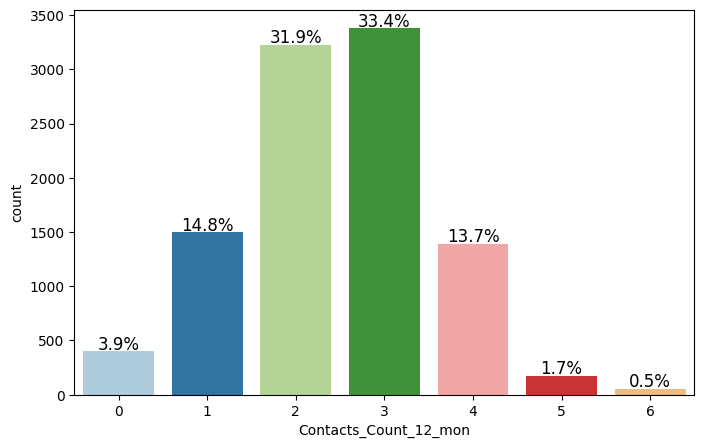

In [45]:
# use label_barplot function to plot the graph
labeled_barplot(df,"Contacts_Count_12_mon", True, False)

**Observations:**
1. 33.4% customers had interacted 3 times with bank staff in last 12 months, followed by 31.9% customers who were contacted 2 times.
2. Very small percentage of customers have interacted for 6 times in last 12 months.

### Credit_Limit

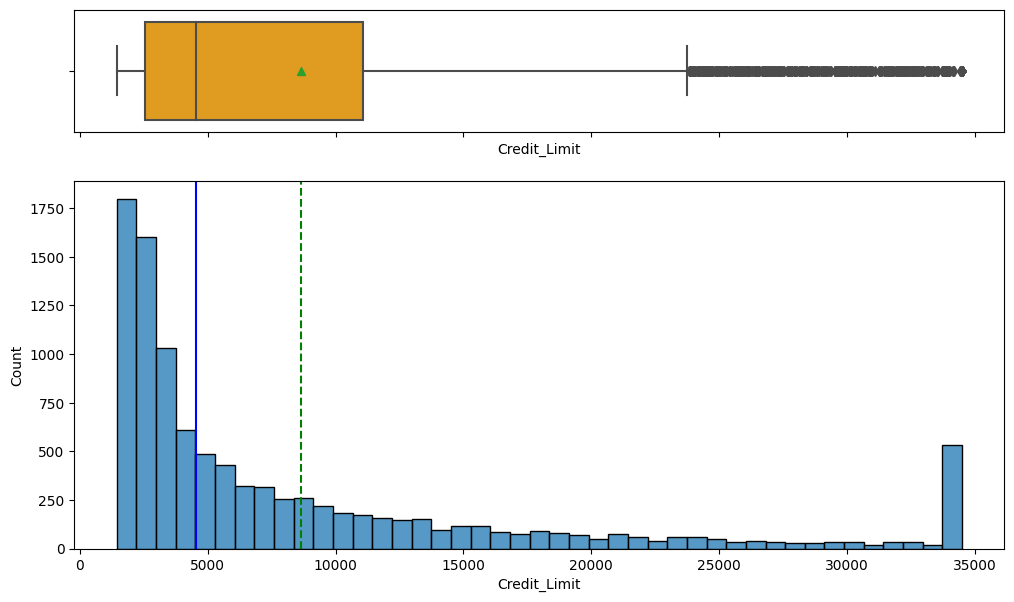

In [46]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Credit_Limit")

**Observations:**

1. Mean is greater than median depicting right skewed data.
2. From our domain knowledge we know that some customers will have higher credit limit compared to others.
3. The data looks normal for the domain and no treatment required.

### Total_Revolving_Bal

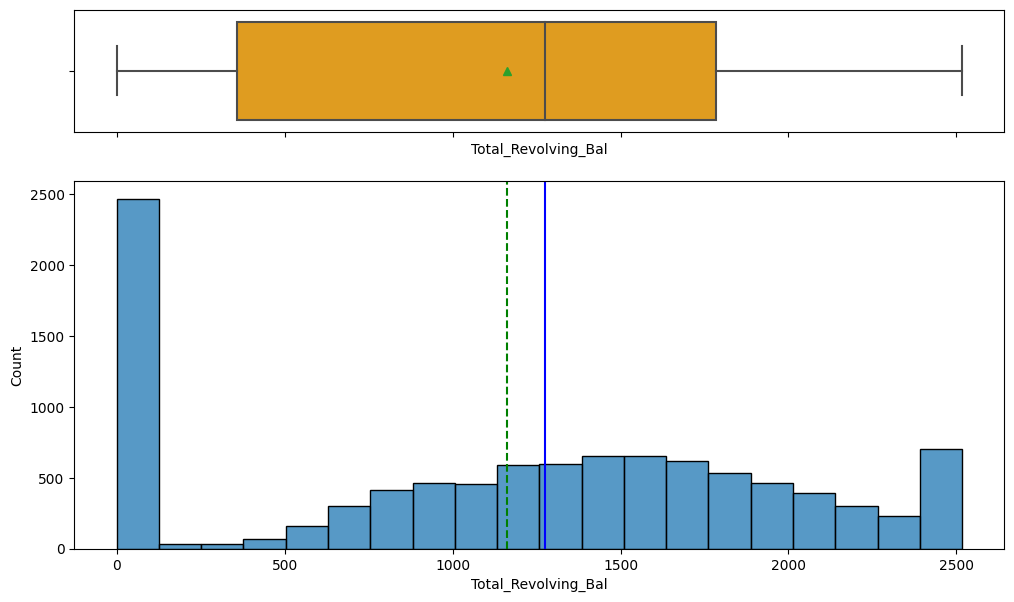

In [47]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Total_Revolving_Bal")

**Observations:**

1. Mean is smaller than median shows slight left skewness.
2. From the domain knowledge we know that customers may or may not use the revolving credit / balance feature on their cards.
3. The data looks right fit for domain and no treatment required.

### Avg_Open_To_Buy

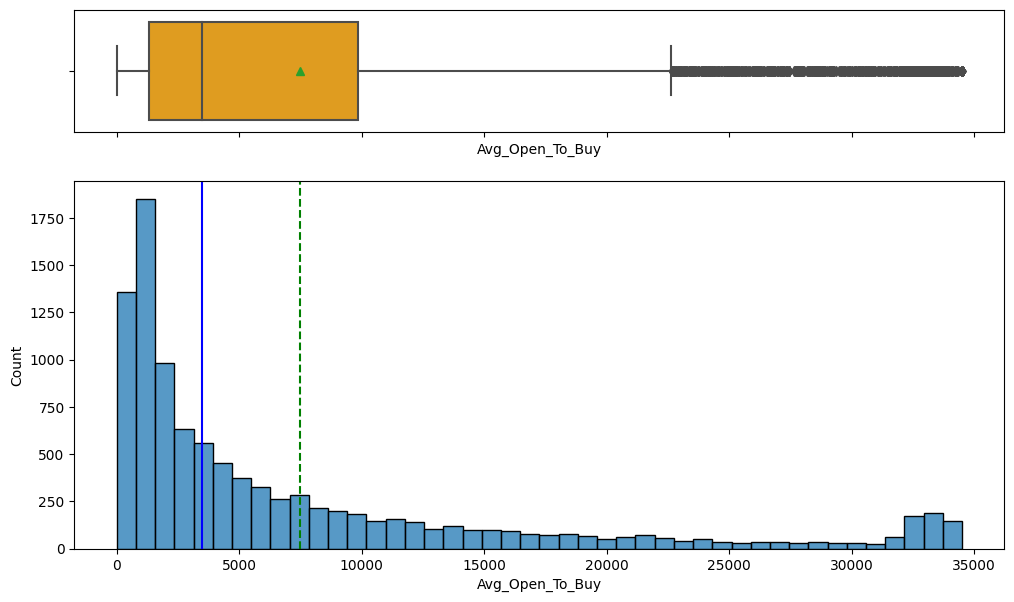

In [48]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Avg_Open_To_Buy")

**Observations:**

1. Mean is greater than median depicting right skewed data.
2. From our domain knowledge we know that customers may or may not utlise the entire limit available on card.
3. The data looks normal for the domain and no treatment required.

### Total_Amt_Chng_Q4_Q1

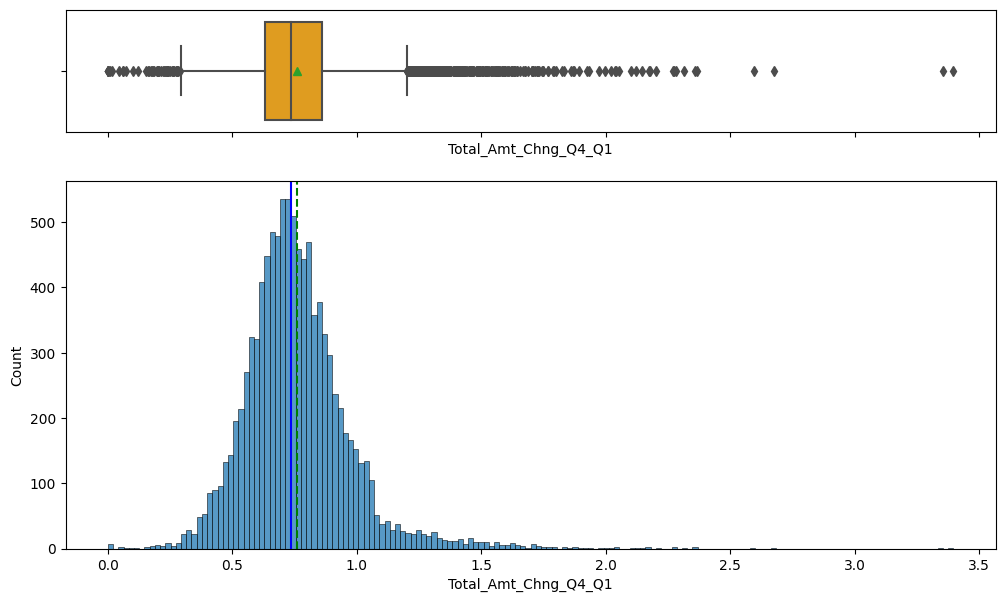

In [49]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Total_Amt_Chng_Q4_Q1")

**Observations:**

1. Mean is slightly greater than median.
2. The variable represents a comparision between utilisation of Q4 as compared to Q1.
3. The data looks normal for the domain and no treatment required.

### Total_Trans_Amt

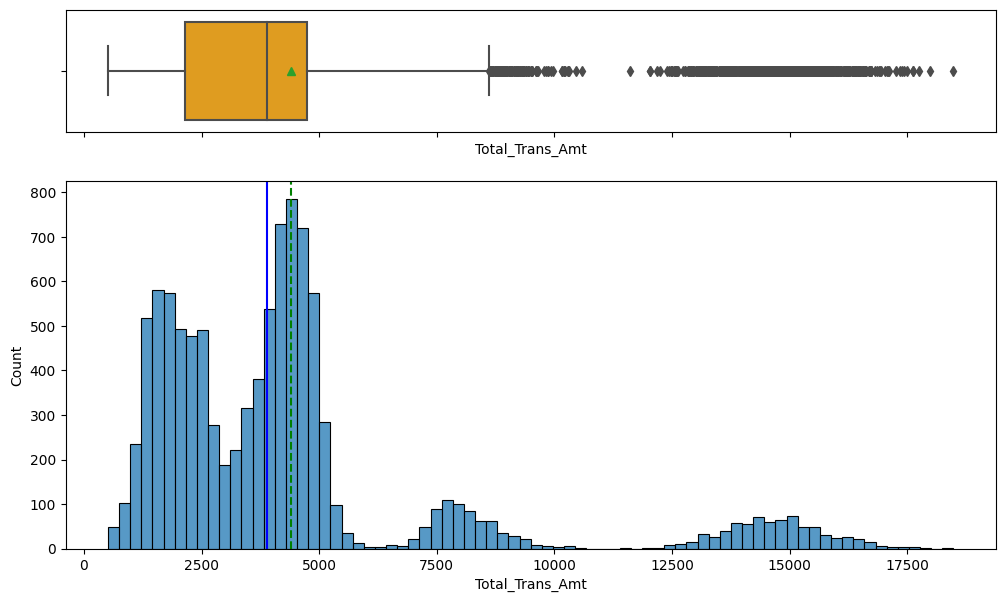

In [50]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Total_Trans_Amt")

**Observations:**

1. Mean is slightly greater than median.
2. Some customers are likely to spend more on credit card, which makes data ligitimate and can be used as is.
3. The data looks normal for the domain and no treatment required.

### Total_Trans_Ct

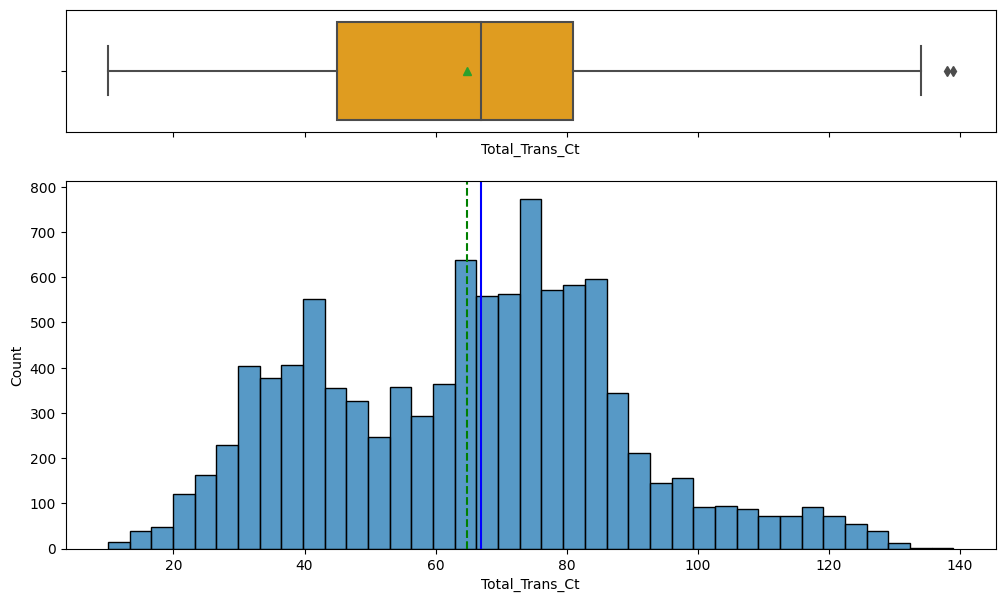

In [51]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Total_Trans_Ct")

In [52]:
df.loc[df["Total_Trans_Ct"] > 130]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
9213,719413383,1,32,M,1,Uneducated,Single,$60K - $80K,Silver,36,2,3,1,33711.0,1437,32274.0,0.942,14880,134,0.654,0.043
9261,716430933,1,46,F,4,Graduate,Single,Less than $40K,Blue,36,2,1,2,3973.0,0,3973.0,0.890,13740,131,0.819,0.000
9269,711010683,1,35,M,3,High School,Married,$40K - $60K,Blue,27,1,2,3,14382.0,1950,12432.0,0.578,12941,131,0.819,0.136
9324,708163758,1,41,M,3,Graduate,Married,$120K +,Blue,33,2,4,3,34516.0,638,33878.0,0.724,13085,139,0.675,0.018
9339,715728108,1,27,F,0,Graduate,Married,Less than $40K,Blue,36,1,1,2,4548.0,1450,3098.0,0.844,14330,131,0.638,0.319
9586,784868958,1,56,F,1,High School,Married,Less than $40K,Blue,49,1,2,1,17542.0,2517,15025.0,0.800,13939,138,0.792,0.143
9629,709015833,1,42,M,2,Graduate,Single,$60K - $80K,Silver,36,3,3,2,34516.0,0,34516.0,0.774,12920,132,0.737,0.000
9728,710699283,1,46,M,2,Graduate,Single,$120K +,Blue,28,1,1,1,7790.0,1921,5869.0,0.789,14567,131,0.617,0.247
9841,715601808,1,50,M,3,Graduate,Married,$120K +,Blue,41,4,2,3,34516.0,2253,32263.0,1.032,16692,131,0.795,0.065
10085,717714633,1,49,M,3,Uneducated,Married,$120K +,Gold,38,4,3,4,14938.0,0,14938.0,0.737,15277,131,0.724,0.000


**Observations:**

1. Mean is slightly smaller than median.
2. The data largely looks balanced.
3. Few customers have used their card more than the other customers.
4. The data looks good and no treatment required.

### Total_Ct_Chng_Q4_Q1

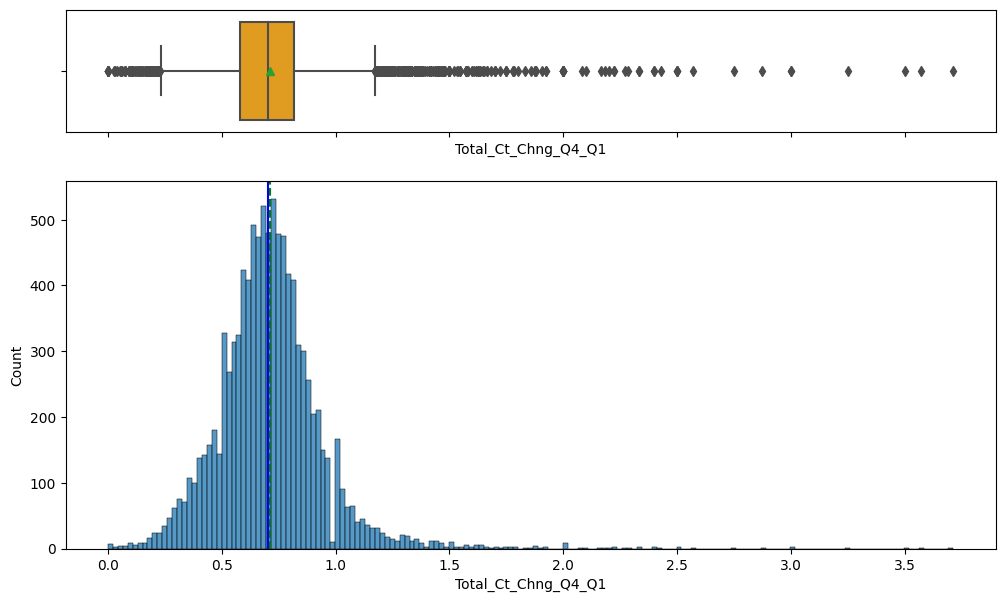

In [53]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Total_Ct_Chng_Q4_Q1")

**Observations:**

1. Mean is almost equal to median.
2. The variable represents a comparision between utilisation of Q4 as compared to Q1.
3. The data looks normal for the domain and no treatment required.

### Avg_Utilization_Ratio

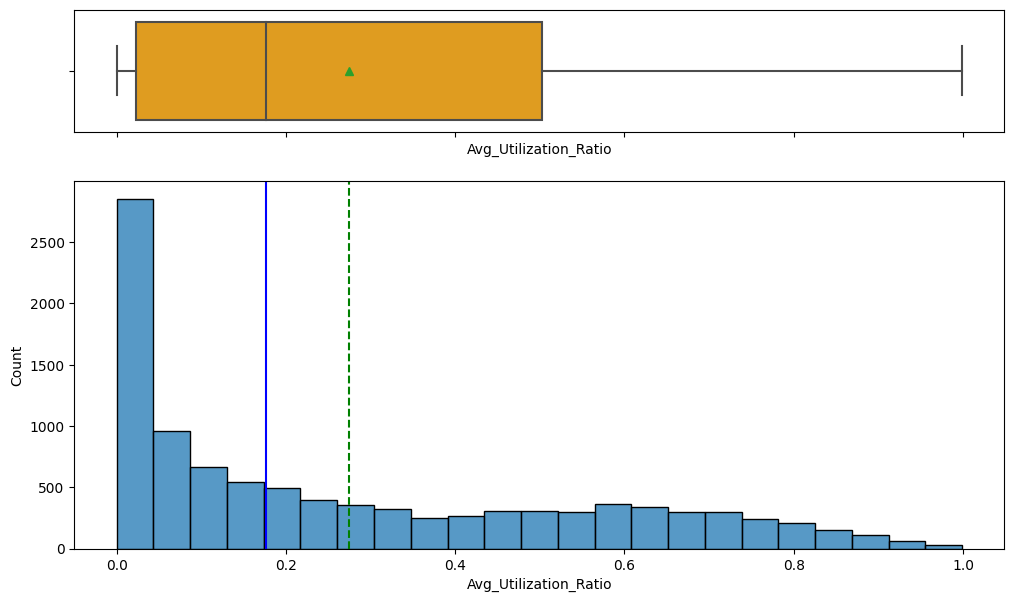

In [54]:
# use the defined function histogram_boxplot to plot the graphs
histogram_boxplot(df,"Avg_Utilization_Ratio")

**Observations:**

1. Mean is greater than median, the data looks right skewed.
2. Some customers are likely to spend more on credit card, which makes data ligitimate and can be used as is.
3. The data looks normal for the domain and no treatment required.

## Bivariate Analysis

### Comparision of all numerical variables with Attrition_Flag

In [55]:
# for all numerical variables draw box plots
#plt.figure(figsize=(20,30))
#for i, variable in enumerate(num_cols):
 #                    plt.subplot(5,3,i+1)
  #                   sns.boxplot(df["Attrition_Flag"],df[variable],palette="Set1")
   #                 plt.title(variable)
#plt.show()

**Observations:**
1. Existing customers have slightly larger Credit_Limits.
2. Existing customers have larger Revolving_Balance.
3. Transaction_Amounts of existing customers are higher than attrited customers, which indicates some customers may have left as they may be using other credit cards OR they rarely use Credit Cards for purchases.
4. Average Utilisation is higher in existing customers.
5. Inactivity during last 12 months has very less role to play.
6. Customer_Age is also not impacting the attrition.

### Gender VS Attrition_Flag

Attrition_Flag     0     1    All
Gender                           
All             1627  8500  10127
F                930  4428   5358
M                697  4072   4769
------------------------------------------------------------------------------------------------------------------------


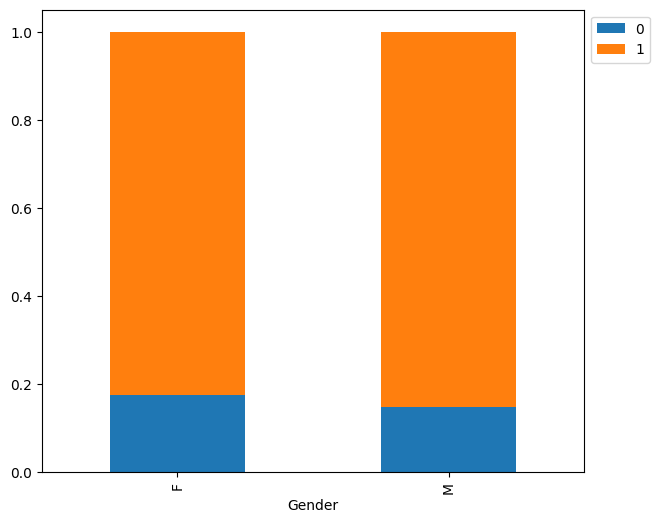

In [56]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Gender", "Attrition_Flag")

**Observations:**

Number of Male Customers closing the Credit Card account is slighlty lesser than Female Customers.

### Education_Level VS Attrition_Flag

Attrition_Flag      0     1    All
Education_Level                   
All              1627  8500  10127
Graduate          743  3904   4647
High School       306  1707   2013
Uneducated        237  1250   1487
College           154   859   1013
Doctorate          95   356    451
Post-Graduate      92   424    516
------------------------------------------------------------------------------------------------------------------------


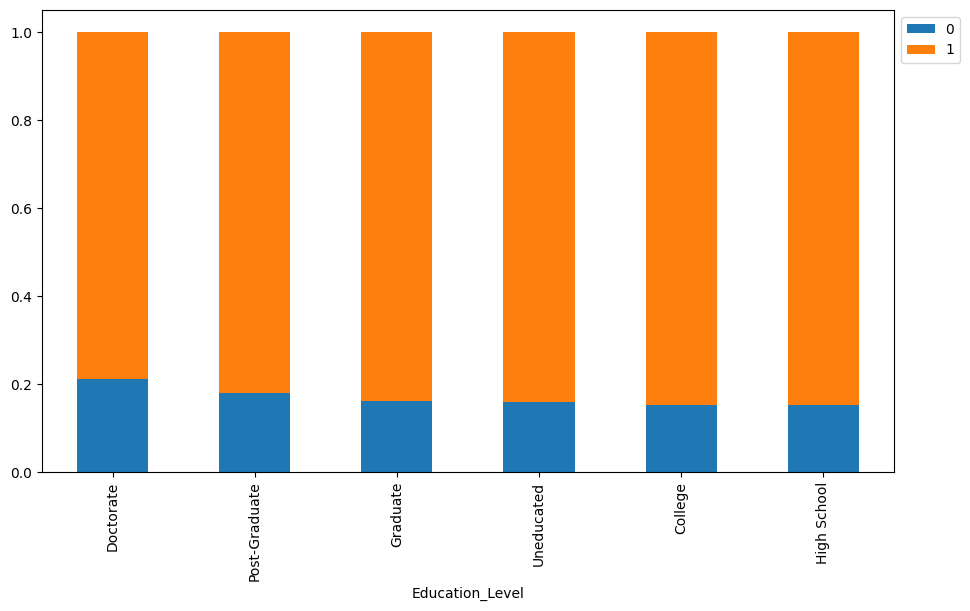

In [57]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Education_Level", "Attrition_Flag")

**Observations:**

1. People with Doctorate degree tend to leave the Credit Card program more than other Education_Levels.
2. Education_Level other than Doctorate dosent show significant impact on attrition.
3. Data entry error / missing data cases should be reduced for future data capture to avoid NULL Values thus resulting into seperate category.

### Marital_Status VS Attrition_Flag

Attrition_Flag     0     1    All
Marital_Status                   
All             1627  8500  10127
Married          838  4598   5436
Single           668  3275   3943
Divorced         121   627    748
------------------------------------------------------------------------------------------------------------------------


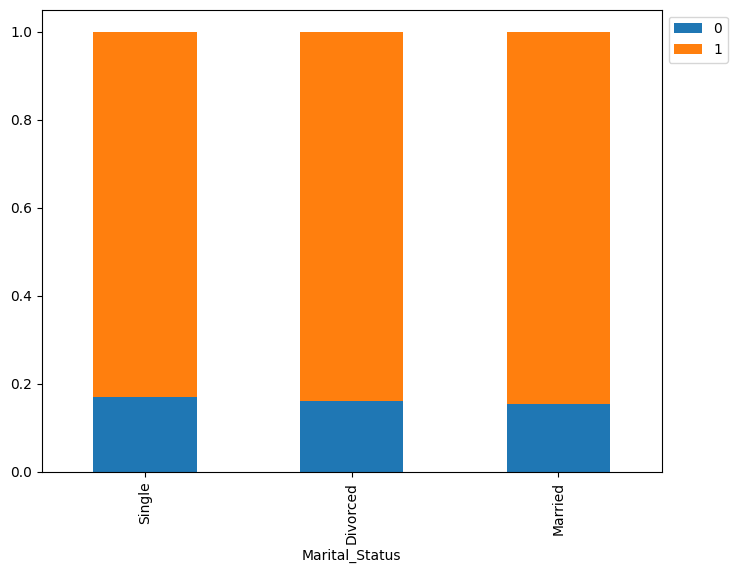

In [58]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Marital_Status", "Attrition_Flag")

**Observations:**

1. Married Customers are less likely to close the credit card compared to other Statuses.
2. It is recommended that business captures more accurate information for the variable in future to avoid NULL Values.

### Income_Category VS Attrition_Flag

Attrition_Flag      0     1    All
Income_Category                   
All              1627  8500  10127
Less than $40K    799  3874   4673
$40K - $60K       271  1519   1790
$80K - $120K      242  1293   1535
$60K - $80K       189  1213   1402
$120K +           126   601    727
------------------------------------------------------------------------------------------------------------------------


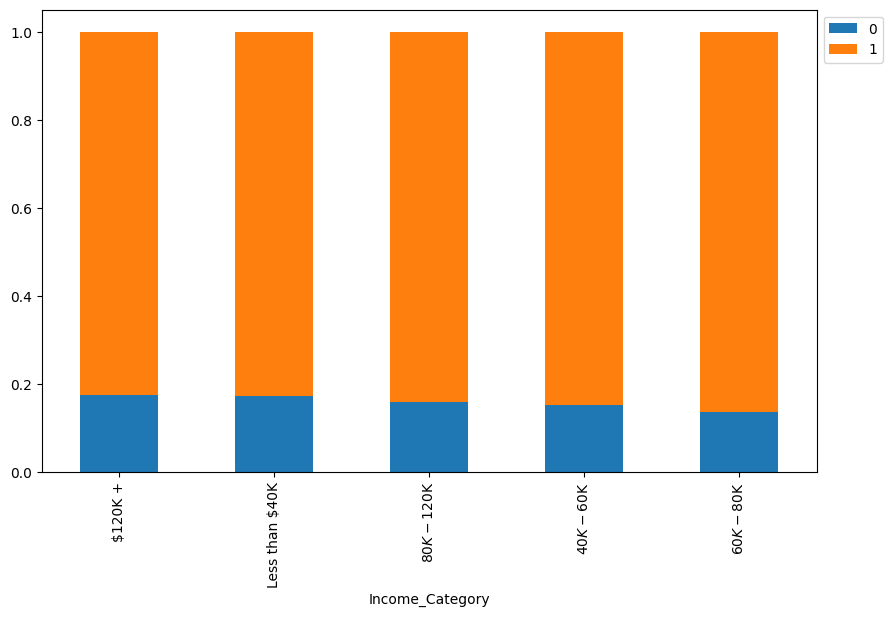

In [59]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Income_Category", "Attrition_Flag")

**Observations:**
1. Customers with income greater that $120K and less than $40K are more likely to close the credit card.
2. Customers within income range of $60K and $80K are less likely to leave.
3. Data Entry error should be avoided to have more meaningful insights.

### Card_Category VS Attrition_Flag

Attrition_Flag     0     1    All
Card_Category                    
All             1627  8500  10127
Blue            1519  7917   9436
Silver            82   473    555
Gold              21    95    116
Platinum           5    15     20
------------------------------------------------------------------------------------------------------------------------


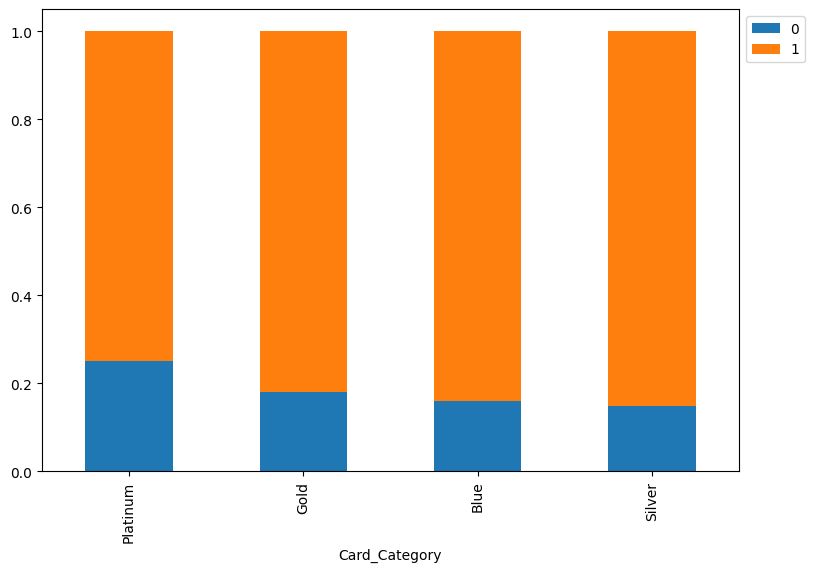

In [60]:
# use the defined function stacked_barplot to plot the graphs
stacked_barplot(df, "Card_Category", "Attrition_Flag")

**Observations:**

Platinum card members are most likely to close the credit card compared to other categories.

## Multivariate Analysis

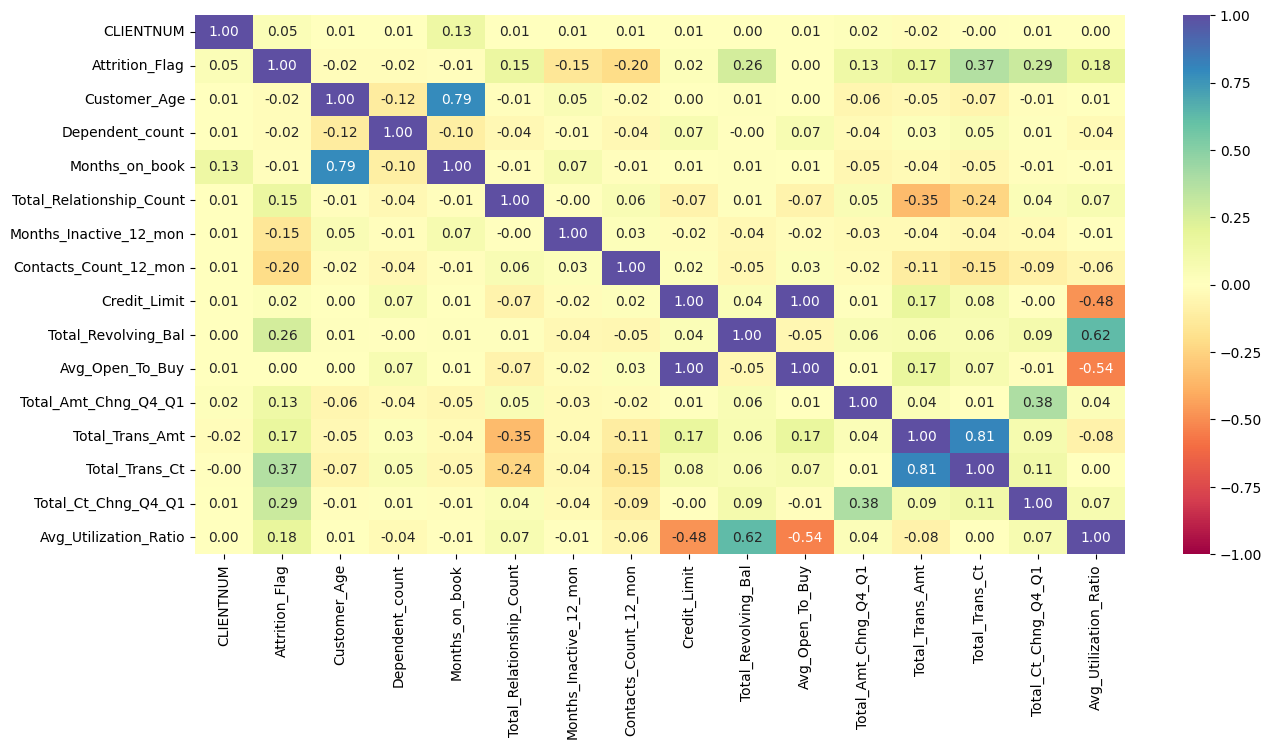

In [61]:
# heatmap for correlation
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations:**

1. Avg_Utilization_Ratio shows significant correlation with Total_Revolving_Bal.
2. Ang_Open_To_Buy is highly correlated to Credit_Limit.
3. Customer_Age is highly correlated to Months_on_book.
4. Avg_Utilization_Ratio is negatively correlated to Credit_Limit and Ang_Open_To_Buy.
5. Total_Trans_Amt is highly correlated to Total_Trans_Ct as they are value and volume representation of Transactional Data.

In [62]:
# heatmap for correlation
# sns.pairplot(df,hue="Attrition_Flag")

**Observations:**

As we have seen during bivariate analysis there are no clear indicators of attrition as all variables show similar data for both existing customers and attrited customers.

## Outliers Treatment

### Draw boxplot for outliers in numerical columns

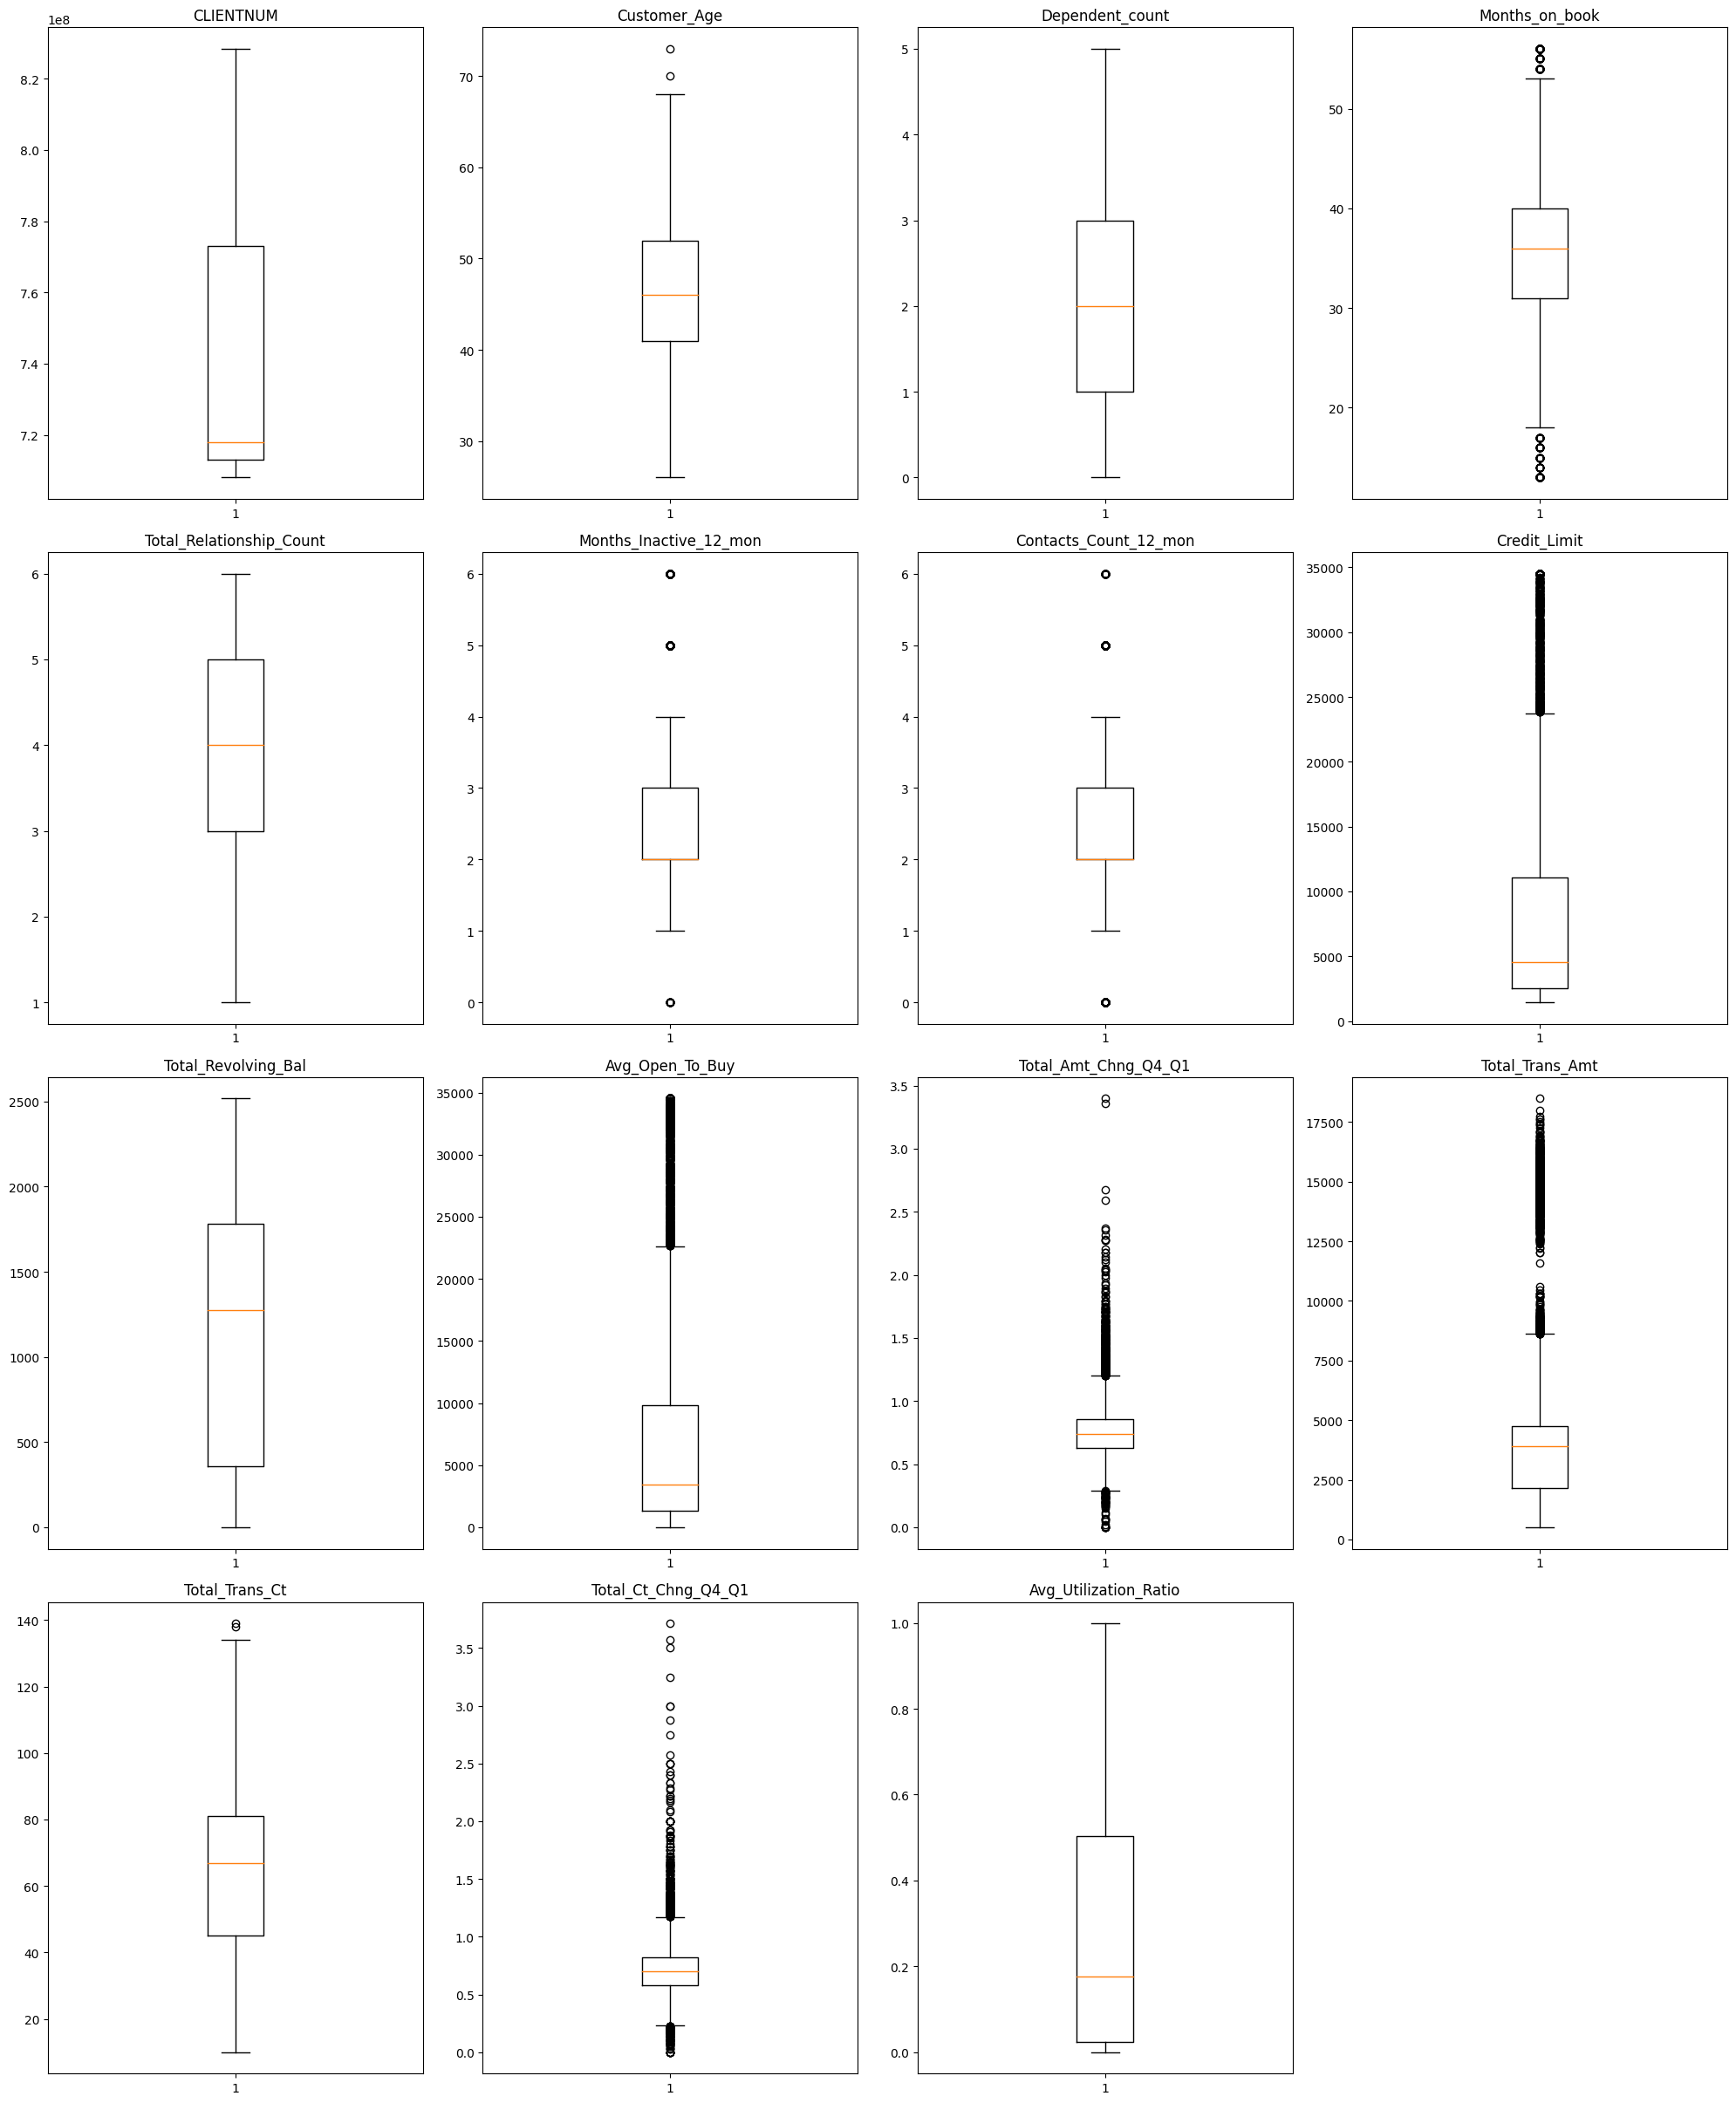

In [63]:
# check the outliers before treating
plt.figure(figsize=(20, 30))

for i, variable in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Validate the outliers using IQR

In [64]:
# find the 25th percentile and 75th percentile.
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Inter Quantile Range (75th percentile - 25th percentile)
IQR = Q3 - Q1

# find lower and upper bounds for all values. All values outside these bounds are outliers
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR

((num_cols<lower)|(num_cols>upper)).sum()/len(df)*100

Attrition_Flag              0.000000
Avg_Open_To_Buy             9.509233
Avg_Utilization_Ratio       0.000000
CLIENTNUM                   0.000000
Contacts_Count_12_mon       6.211119
Credit_Limit                9.716599
Customer_Age                0.019749
Dependent_count             0.000000
Months_Inactive_12_mon      3.268490
Months_on_book              3.811593
Total_Amt_Chng_Q4_Q1        3.910339
Total_Ct_Chng_Q4_Q1         3.890590
Total_Relationship_Count    0.000000
Total_Revolving_Bal         0.000000
Total_Trans_Amt             8.847635
Total_Trans_Ct              0.019749
dtype: float64

**Observations:**

1. Credit_Limit, Contacts_Count_12_mon, Total_Trans_Ct and Avg_Open_To_Buy show heavy outliers.
2. Month_on_book, Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1 and Months_Inactive_12_mon show few outliers.
3. As we have seen during Univariate analysis, the variables does show outlers however these are valid business data and we should consider these in model_building.

## Prepare Data for Model Building

### Split data into Dependent and Independent Variables

In [65]:
# Separating target variable and other variables
#X = df.drop(["CLIENTNUM","Attrition_Flag","Total_Ct_Chng_Q4_Q1","Total_Amt_Chng_Q4_Q1","Avg_Utilization_Ratio"], axis=1)
#X = df.drop(["CLIENTNUM","Attrition_Flag"], axis=1)
X = df.drop(["Attrition_Flag"], axis=1)
y = df["Attrition_Flag"]

### Apply onehot encoding

In [66]:
X = pd.get_dummies(data=X, drop_first=True)

### Split data into Training, Validation and Test Sets

Training Set to have 60% data and Validation and Testing sets to have 20% data each

In [67]:
# Splitting data into training, validation and test set:

# first we split data into 2 parts, say temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 30) (2026, 30) (2026, 30)


### Create oversampled training set

In [68]:
# use SMOTE - Synthetic Minority Over Sampling Technique to create oversampled training sets
sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)

# fit the sampler and created undersampled data
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

### Create undersampled training set

In [69]:
# use randomundersampler for dataset processing
rus = RandomUnderSampler(random_state=1)

# fit the sampler and created undersampled data
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

## Model Building

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer will close the Credit Card Account and the customer doesn"t - Loss of resources.
2. Predicting a customer will not close ther Credit Card Account and the customer does - Loss of revenue / business.

#### Which case is more important?
* Predicting that customer will not close the Credit Card but he does i.e. losing on a potential source of income for the company because that customer will not be focussed upon by the business team to provide better services.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company wants Recall to be maximized, greater the Recall lesser the chances of false negatives.

### Identify the models to be built

In [70]:
 # Empty list to store all the models
models = []

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("Decision tree", DecisionTreeClassifier(random_state=1)))

### Build different models on Training Set using KFold and cross_val_score.

In [71]:
# Empty list to store all model"s CV scores
results = []

# best_scores
best_scores = []

# Empty list to store name of the models
names = []

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance on Training Set:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

    best_scores.append(round(cv_result.mean() * 100,2))

print("\n" "Training Set Performance:" "\n")

# fit and predict the models training set
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train)) * 100
    print("{}: {}".format(name, scores))

print("\n" "Validation Set Performance:" "\n")

# predict the models on validation set
for name, model in models:
    scores = recall_score(y_val, model.predict(X_val)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance on Training Set:

Logistic regression: 100.0
Bagging: 97.33314091092767
Random forest: 98.58810059843368
Gradient Boosting: 98.86261040235524
Adaboost: 97.8427716523312
Xgboost: 98.60757374588698
Decision tree: 95.97979564740517

Training Set Performance:

Logistic regression: 100.0
Bagging: 99.76465973720337
Random forest: 100.0
Gradient Boosting: 99.27436752304374
Adaboost: 98.41145322612277
Xgboost: 100.0
Decision tree: 100.0

Validation Set Performance:

Logistic regression: 100.0
Bagging: 97.76470588235294
Random forest: 98.47058823529412
Gradient Boosting: 98.82352941176471
Adaboost: 97.88235294117648
Xgboost: 99.11764705882354
Decision tree: 96.70588235294117


#### Boxplot of scores

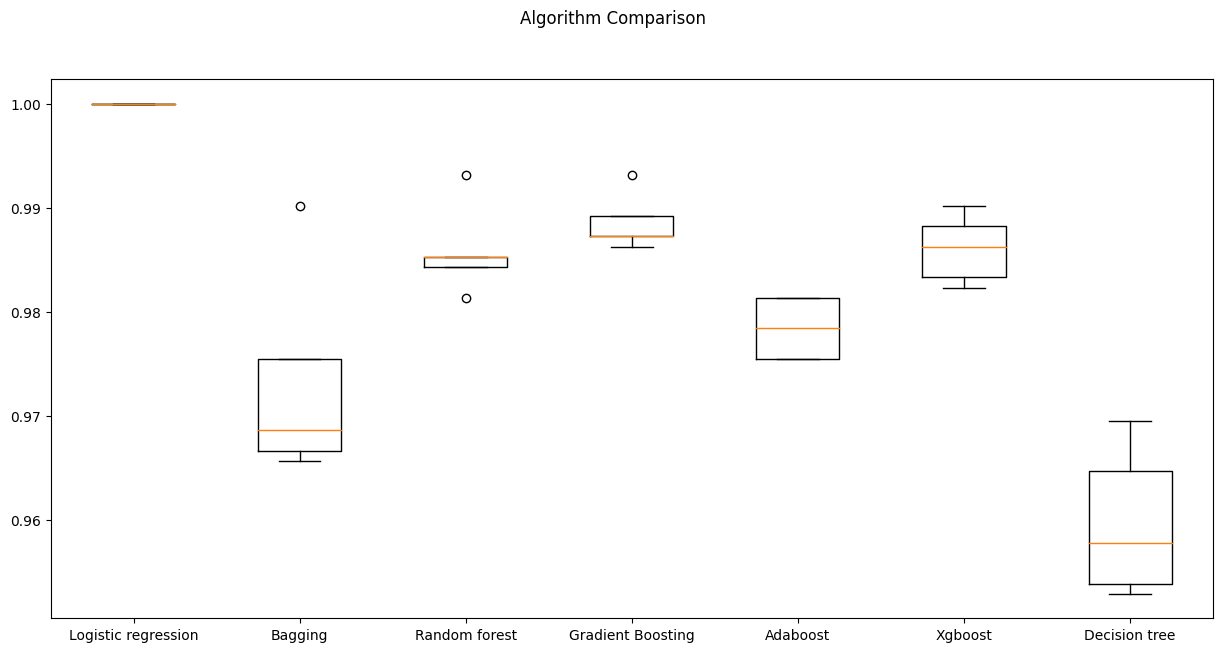

In [72]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

**Observations:**

1. We see that Logistic Regression, Random Forest, XGBoost and Decision Tree models are over fiting on the training set.
2. However the cross_validation has reduced the over fitting to some extent.
3. Random Forest, Gradient Boosting and XGBoost gives best perfomance and we would want to tune them for further improvements.
4. The boxplot shows that Gradient Boosting has 1 outlier and Random Forest has 2.
4. Let us also build these models on Over and Under sampled datasets to validate our undertstanding.

### Build different models on Oversampled Training Set using KFold and cross_val_score.

In [73]:
# Empty list to store all model"s CV scores
results_over = []

# best_scores
best_scores_over = []

# Empty list to store name of the models
names_over = []

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance on Oversampled Training Set:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

    best_scores_over.append(round(cv_result.mean() * 100,2))

print("\n" "Oversampled Training Performance:" "\n")

# fit and predict the models training set
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_over = recall_score(y_train_over, model.predict(X_train_over)) * 100
    print("{}: {}".format(name, scores_over))

print("\n" "Validation Set Performance:" "\n")

# predict the models on validation set
for name, model in models:
    scores = recall_score(y_val, model.predict(X_val)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance on Oversampled Training Set:

Logistic regression: 100.0
Bagging: 93.54790355789028
Random forest: 96.15628547788106
Gradient Boosting: 96.70532432796476
Adaboost: 95.4697800611903
Xgboost: 97.58786969154689
Decision tree: 92.90072928091749

Oversampled Training Performance:

Logistic regression: 100.0
Bagging: 99.4508727201412
Random forest: 100.0
Gradient Boosting: 97.37203373210434
Adaboost: 95.82271033535987
Xgboost: 100.0
Decision tree: 100.0

Validation Set Performance:

Logistic regression: 100.0
Bagging: 95.17647058823529
Random forest: 96.88235294117648
Gradient Boosting: 96.76470588235294
Adaboost: 95.47058823529412
Xgboost: 98.11764705882354
Decision tree: 93.82352941176471


#### Boxplot of scores

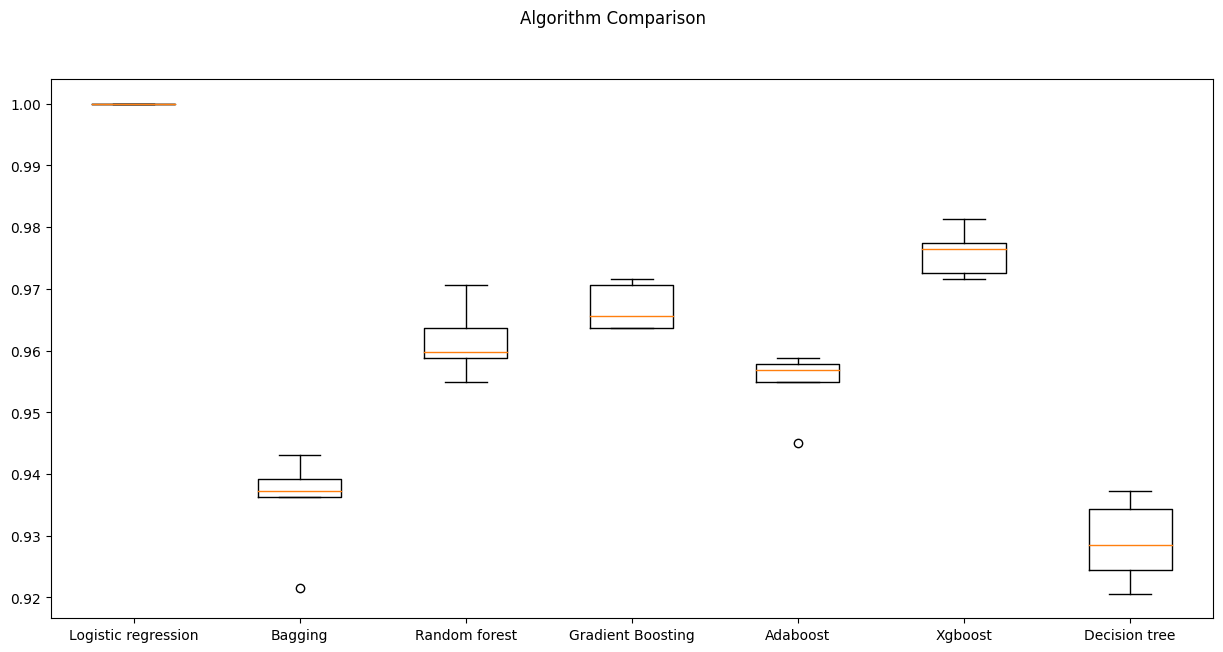

In [74]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names_over)

plt.show()

**Observations:**

1. We see that Logistic Regression, Random Forest, XGBoost and Decision Tree models are over fiting on the oversampled training set as well.
2. However the cross_validation has reduced the over fitting.
3. Random Forest, Gradient Boosting and XGBoost gives best perfomance and we would want to tune them for further improvements.
5. Let us also build these models on Under sampled datasets to validate our undertstanding.

### Build different models on Undersampled Training Set using KFold and cross_val_score.

In [75]:
# Empty list to store all model"s CV scores
results_under = []

# best scores
best_scores_under = []

# Empty list to store name of the models
names_under = []

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance on Undersampled Training set:" "\n")

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scoring, cv=kfold
    )
    results_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

    best_scores_under.append(round(cv_result.mean() * 100,2))

print("\n" "Undersampled Training Performance:" "\n")

# fit and predict the models training set
for name, model in models:
    model.fit(X_train_under, y_train_under)
    scores_under = recall_score(y_train_under, model.predict(X_train_under)) * 100
    print("{}: {}".format(name, scores_under))

print("\n" "Validation Set Performance:" "\n")

# predict the models on validation set
for name, model in models:
    scores = recall_score(y_val, model.predict(X_val)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance on Undersampled Training set:

Logistic regression: 71.96232339089482
Bagging: 89.95604395604396
Random forest: 91.49450549450549
Gradient Boosting: 93.33961276818418
Adaboost: 91.18942961800104
Xgboost: 93.95447409733123
Decision tree: 87.80847723704866

Undersampled Training Performance:

Logistic regression: 62.090163934426236
Bagging: 99.38524590163934
Random forest: 100.0
Gradient Boosting: 97.02868852459017
Adaboost: 94.4672131147541
Xgboost: 100.0
Decision tree: 100.0

Validation Set Performance:

Logistic regression: 63.0
Bagging: 91.64705882352942
Random forest: 94.35294117647058
Gradient Boosting: 95.11764705882354
Adaboost: 92.82352941176471
Xgboost: 95.94117647058825
Decision tree: 91.64705882352942


#### Boxplot of scores

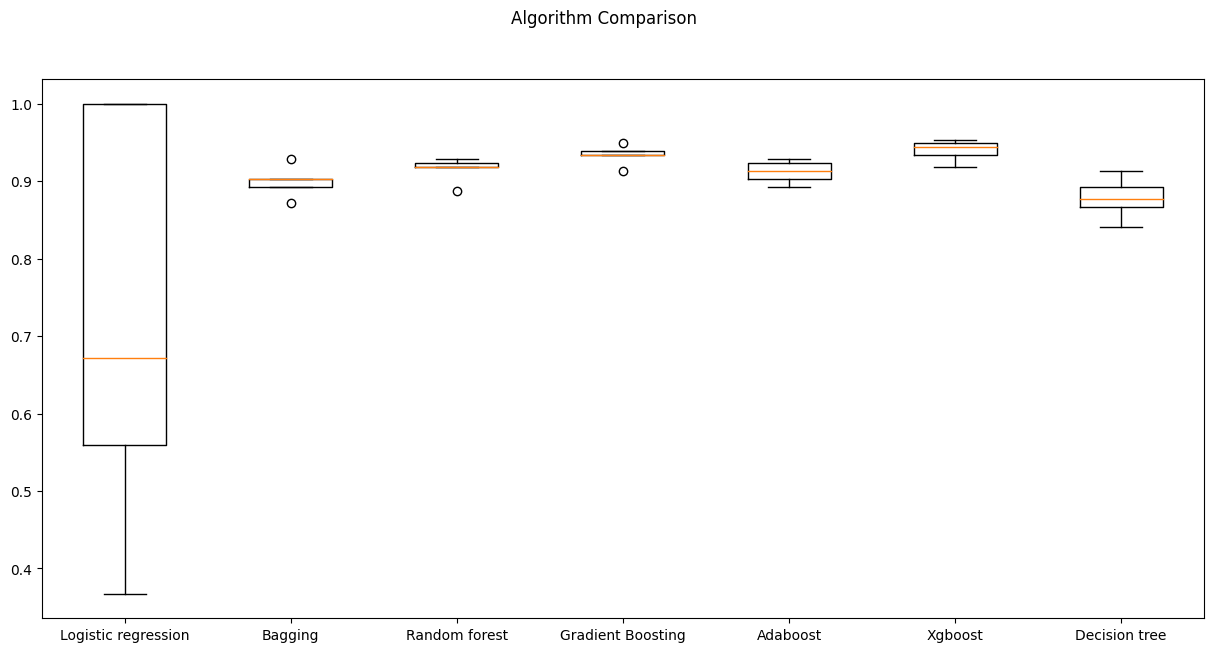

In [76]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_under)
ax.set_xticklabels(names_under)

plt.show()

**Observations:**

1. We see that Random Forest, XGBoost and Decision Tree models are over fiting on the undersampled training set as well.
2. However the cross_validation has reduced the over fitting.
3. Random Forest, Gradient Boosting and XGBoost gives best perfomance on undersampled training set.
4. The boxplot shows that Gradient Boosting has 2 outliers and Random Forest has 1 outlier.

### Compare model performance

In [77]:
# create dataframe
comparison_frame = pd.DataFrame({"Model":["Logistic regression","Bagging","Random forest","Gradient Boosting","Adaboost",
                                          "Xgboost","Decision tree"],
                                          "Training Set": best_scores, "Oversampled Training": best_scores_over,
                                          "Undersampled Training": best_scores_under})
comparison_frame

,Model,Training Set,Oversampled Training,Undersampled Training
0,Logistic regression,100.00,100.00,71.96
1,Bagging,97.33,93.55,89.96
2,Random forest,98.59,96.16,91.49
3,Gradient Boosting,98.86,96.71,93.34
4,Adaboost,97.84,95.47,91.19
5,Xgboost,98.61,97.59,93.95
6,Decision tree,95.98,92.90,87.81


**Observations:**

1. Logistic regression gives best score on Training and Oversampled Training sets.
2. But Random Forest, Gradient Boost and Xgboost gives us consistent scores on Training, Oversampled and Undersampled data.
3. We have alse seen that these three models give us generalised performance on the validation set as well.
4. We can continue with hyper tuning these models and see if the performance improves / generalises.
5. We will build the hypertuned models on Training set, as all models give best recall on the same.

## Hyperparameter Tuning

### RandomForestClassifier

#### GridSearchCV

#### Define Parameters

In [78]:
# random forest classifier
rfc = RandomForestClassifier(random_state=1)

# type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# grid of parameters to choose from
param_grid_rfc = {"n_estimators": np.arange(50,150,50),
              "min_samples_leaf": np.arange(1,6,1),
              "max_features":["log2",0.7,0.9,"auto"],
              "max_samples": np.arange(0.3, 0.7, None),
              "max_depth":np.arange(1,5,1),
             }

#### Run Grid Search and fit the model

In [79]:
%%time

# run the grid search
rfc_tuned1 = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

# Fitting parameters in GridSeachCV
rfc_tuned1.fit(X_train, y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(rfc_tuned1.best_params_,rfc_tuned1.best_score_))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best parameters are {'max_depth': 1, 'max_features': 'log2', 'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 50} with CV score=1.0:
CPU times: user 4.78 s, sys: 745 ms, total: 5.53 s
Wall time: 3min 45s


#### Use the best parameters and train a model

In [80]:
# building model with best parameters
rfc_tuned_gcv = RandomForestClassifier(
    random_state=1,
    max_features="log2",
    max_samples=0.3,
    max_depth=1,
    min_samples_leaf=1,
    n_estimators=50,
)

# Fit the model on training data
rfc_tuned_gcv.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features='log2', max_samples=0.3,
                       n_estimators=50, random_state=1)

#### Evaluate the model performance

In [81]:
# calculating different metrics
rfc_tuned_gcv_score, rfc_tuned_gcv_list = get_metrics_score(
    rfc_tuned_gcv, False
)

# model performance
rfc_tuned_gcv_score

,DataSet,Accuracy,Recall,Precision,F1
0,Training,0.839342,1.0,0.839342,0.912654
1,Validation,0.839092,1.0,0.839092,0.912507
2,Testing,0.839585,1.0,0.839585,0.912798


#### Draw Confusion Matrix on Validation Set

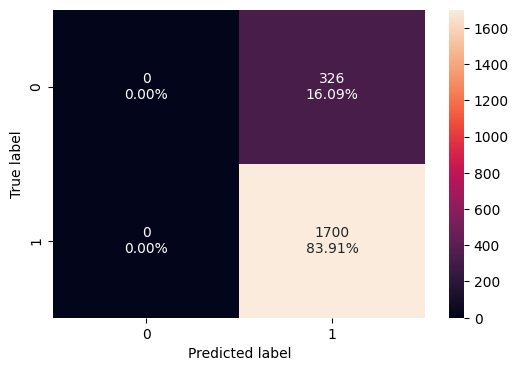

In [82]:
# use draw_matrix function
draw_matrix(rfc_tuned_gcv, X_val, y_val)

**Observations:**

1. We see that Hypertuning with Best Parameters identied by GridSearchCV, of the RandomForestClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

#### RandomizedSearchCV

#### Run Randomized Search and fit the model

In [83]:
%%time

# Calling RandomizedSearchCV
rfc_tuned2 = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid_rfc, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

# Fitting parameters in RandomizedSearchCV
rfc_tuned2.fit(X_train, y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(rfc_tuned2.best_params_,rfc_tuned2.best_score_))

Best parameters are {'n_estimators': 100, 'min_samples_leaf': 5, 'max_samples': 0.3, 'max_features': 0.9, 'max_depth': 1} with CV score=1.0:
CPU times: user 1.91 s, sys: 229 ms, total: 2.14 s
Wall time: 1min 14s


#### Use the best parameters and train a model

In [84]:
# building model with best parameters
rfc_tuned_rcv = RandomForestClassifier(
    random_state=1,
    max_features=0.9,
    max_samples=0.3,
    min_samples_leaf=5,
    n_estimators=100,
    max_depth=1,
)

# Fit the model on training data
rfc_tuned_rcv.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features=0.9, max_samples=0.3,
                       min_samples_leaf=5, random_state=1)

#### Evaluate the model performance

In [85]:
# calculating different metrics
rfc_tuned_rcv_score, rfc_tuned_rcv_list = get_metrics_score(
    rfc_tuned_rcv, False
)

# model performance
rfc_tuned_rcv_score

,DataSet,Accuracy,Recall,Precision,F1
0,Training,0.839342,1.0,0.839342,0.912654
1,Validation,0.839092,1.0,0.839092,0.912507
2,Testing,0.839585,1.0,0.839585,0.912798


#### Draw Confusion matrix for Validation Set

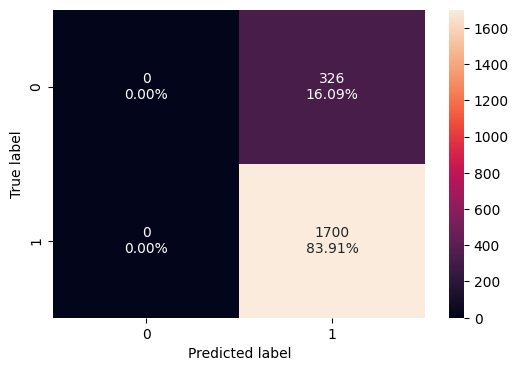

In [86]:
# use draw_matrix function
draw_matrix(rfc_tuned_rcv, X_val, y_val)

**Observations:**

1. We see that Hypertuning with Best Parameters identied by RandomizedSearchCV, of the RandomForestClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

### XGBoostClassifier

#### Define parameters

In [87]:
#defining model
xgb = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid
param_grid_xgb ={"n_estimators":np.arange(50,150,50),
            "scale_pos_weight":[2,5,10],
            "learning_rate":[0.01,0.1,0.2,0.05],
            "gamma":[0,1,3,5],
            "subsample":[0.8,0.9,1],
            "max_depth":np.arange(1,5,1),
            "reg_lambda":[5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#### GridSearchCV

#### Run Grid Search and fit the model

In [88]:
%%time

# Calling GridSearchCV
xgb_tuned1 = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

# Fitting parameters in GridSeachCV
xgb_tuned1.fit(X_train,y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(xgb_tuned1.best_params_,xgb_tuned1.best_score_))

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


KeyboardInterrupt: ignored

#### Use the best params and train a model

In [89]:
# building model with best parameters
xgb_tuned_gcv = XGBClassifier(
    random_state=1,
    n_estimators=50,
    scale_pos_weight=2,
    subsample=0.8,
    learning_rate=0.01,
    gamma=0,
    eval_metric="logloss",
    reg_lambda=5,
    max_depth=1,
)

# Fit the model on training data
xgb_tuned_gcv.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

#### Evaluate the model performance

In [90]:
# calculating different metrics
xgb_tuned_gcv_score, xgb_tuned_gcv_list = get_metrics_score(
    xgb_tuned_gcv, False
)

# model performance
xgb_tuned_gcv_score

,DataSet,Accuracy,Recall,Precision,F1
0,Training,0.839342,1.0,0.839342,0.912654
1,Validation,0.839092,1.0,0.839092,0.912507
2,Testing,0.839585,1.0,0.839585,0.912798


#### Draw Consufion matrix for Validation Set

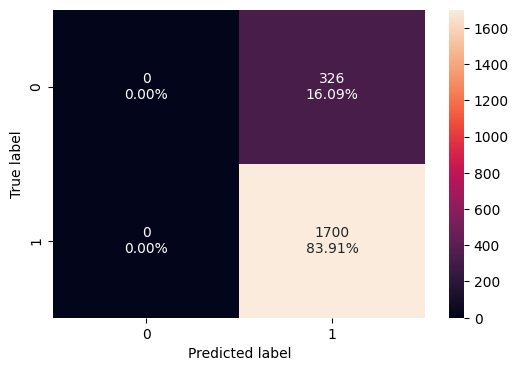

In [91]:
# use draw_matrix function
draw_matrix(xgb_tuned_gcv, X_val, y_val)

**Observations:**

1. We see that Hypertuning with Best Parameters identied by GridSearchCV, of the XGBoostClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

#### RandomizedSearchCV

#### Run Randomized Search and fit the model

In [92]:
%%time

# Calling RandomizedSearchCV
xgb_tuned2 = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

# Fitting parameters
xgb_tuned2.fit(X_train,y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(xgb_tuned2.best_params_,xgb_tuned2.best_score_))

KeyboardInterrupt: ignored

#### Use the best parameters and train a model

In [93]:
# building model with best parameters
xgb_tuned_rcv = XGBClassifier(
    random_state=1,
    n_estimators=100,
    scale_pos_weight=2,
    subsample=0.8,
    learning_rate=0.01,
    gamma=5,
    eval_metric="logloss",
    reg_lambda=10,
    max_depth=1,
)

# Fit the model on training data
xgb_tuned_rcv.fit(X_train, y_train)

KeyboardInterrupt: ignored

#### Evaluate the model performance

In [96]:
# calculating different metrics
xgb_tuned_rcv_score, xgb_tuned_rcv_list = get_metrics_score(
    xgb_tuned_rcv, False
)

# model performance
xgb_tuned_rcv_score

NotFittedError: ignored

#### Draw Confusion Matrix for Validation Set

In [ ]:
# use draw_matrix function
draw_matrix(xgb_tuned_rcv, X_val, y_val)

**Observations:**

1. We see that Hypertuning with Best Parameters identied by RandomizedSearchCV, of the XGBoostClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

### GradientBoostClassifier

#### Define the parameters

In [94]:
# Choose the type of classifier.
gbc = GradientBoostingClassifier(random_state=1)

# Parameter grid
param_grid_gbc ={"n_estimators":np.arange(50,150,50),
            "learning_rate":[0.01,0.1,0.2,0.05],
            "subsample":[0.8,0.9,1],
            "max_depth":np.arange(1,5,1),
            "min_samples_leaf": np.arange(1,6,1),
            "max_features":["log2",0.7,0.9,"auto"],
            "max_depth":np.arange(1,5,1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#### Run Grid Search and fit the model

In [95]:
%%time

# Run the grid search
gbc_tuned1 = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, scoring=scorer, cv=5, n_jobs = -1, verbose= 2)

# fit the model
gbc_tuned1.fit(X_train, y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(gbc_tuned1.best_params_,gbc_tuned1.best_score_))

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


KeyboardInterrupt: ignored

#### Use the best parameters and traing the model

In [97]:
# Choose the type of classifier.
gbc_tuned_gcv = GradientBoostingClassifier (
                    random_state=1,
                    n_estimators=50,
                    learning_rate=0.01,
                    subsample=0.8,
                    max_depth=1,
                    min_samples_leaf=1,
                    max_features="log2",
)

# Fit the model on training data
gbc_tuned_gcv.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='log2',
                           n_estimators=50, random_state=1, subsample=0.8)

#### Evaluate the model performance

In [98]:
# calculating different metrics
gbc_tuned_gcv_score, gbc_tuned_gcv_list = get_metrics_score(
    gbc_tuned_gcv, False
)

# model performance
gbc_tuned_gcv_score

,DataSet,Accuracy,Recall,Precision,F1
0,Training,0.839342,1.0,0.839342,0.912654
1,Validation,0.839092,1.0,0.839092,0.912507
2,Testing,0.839585,1.0,0.839585,0.912798


#### Draw Confusion Matrix on Validation Set

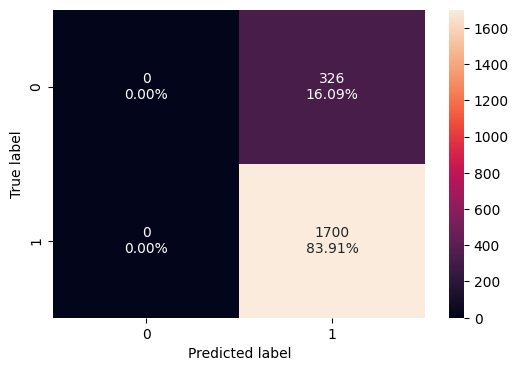

In [99]:
# use draw_matrix function
draw_matrix(gbc_tuned_gcv, X_val, y_val)

**Observations:**

1. We see that Hypertuning with Best Parameters identied by GridSearchCV, of the GradientBoostClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

#### RandomizedSearchCV

#### Run Randomized Search and fit the model

In [100]:
%%time

# Calling RandomizedSearchCV
gbc_tuned2 = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_gbc, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

# Fitting parameters
gbc_tuned2.fit(X_train,y_train)

# print best parameters
print("Best parameters are {} with CV score={}:" .format(gbc_tuned2.best_params_,gbc_tuned2.best_score_))

[09:13:38] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf" } are not used.

Best parameters are {'subsample': 0.8, 'n_estimators': 50, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 1, 'learning_rate': 0.01} with CV score=1.0:
CPU times: user 2.68 s, sys: 351 ms, total: 3.03 s
Wall time: 2min 3s


#### Use the best parameters and train the model

In [115]:
# Choose the type of classifier.
gbc_tuned_rcv = GradientBoostingClassifier (
                    random_state=1,
                    n_estimators=50,
                    learning_rate=0.01,
                    subsample=0.8,
                    max_depth=1,
                    min_samples_leaf=4,
                    max_features=0.7,
)

# Fit the model on training data
gbc_tuned_rcv.fit(X_train, y_train)

ValueError: ignored

#### Evaluate the model performance

In [113]:
# calculating different metrics
gbc_tuned_rcv_score, gbc_tuned_rcv_list = get_metrics_score(
    gbc_tuned_rcv, False
)

# model performance
gbc_tuned_rcv_score

ValueError: ignored

#### Draw the Confusion Matrix on Validation Set

In [112]:
# use draw_matrix function
draw_matrix(gbc_tuned_rcv, X_val, y_val)

ValueError: ignored

**Observations:**

1. We see that Hypertuning with Best Parameters identied by RandomizedSearchCV, of the GradientBoostClassifier has improved the recall to 1 on training set.
2. Performance is consistent on Validation and Testing set as well.
3. Accuracy and Precision scores are also consistent.

### Compare the Model Performance

In [109]:
# create dataframe
comparison_frame1 = pd.DataFrame({"Model":["Accuracy - Training",
                                        "Accuracy - Validation",
                                        "Accuracy - Test",
                                        "Recall - Training",
                                        "Recall - Validation",
                                        "Recall - Test",
                                        "Precision - Training",
                                        "Precision - Validation",
                                        "Precision - Test",
                                        "F1 - Training",
                                        "F1 - Validation",
                                        "F1 - Test"],
                                        "Random Forest - Grid Search": rfc_tuned_gcv_list,
                                        "Random Forest - Randomized Search": rfc_tuned_rcv_list,
                                        "XG Boost - Grid Search": xgb_tuned_gcv_list,
                                        "XG Boost - Randomized Search": xgb_tuned_rcv_list,
                                        "Gradient Boost - Grid Search": gbc_tuned_gcv_list,
                                        "Gradient Boost - Randomized Search": gbc_tuned_rcv_list}
                                )

comparison_frame1

NameError: ignored

**Observations:**

1. From the above comparision we see that all the hypertuned models give same recall.
2. Accuracy and Precision is also consistent accross all datasets.
3. All 6 models are giving consistent performance.
4. XGBoostClassifier is tuned with maximum parameters using RandomizedSearchCV, we assume that this model will provide us better fitment and performance on future datasets.
4. Let us also check the important features before proceeding.

#### Feature importance for RandomForest tuned with RandomizedSearchCV

In [114]:
feature_names = X.columns
importances = xgb_tuned_rcv.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

NotFittedError: ignored

**Observations:**

Total_Trans_Ct is the most important variable, followed by Total_Ct_Chng_Q4_Q1 and Total_Trans_Amt.

## Pipelines for productionizing the model
Now, we have a final model. let's use pipelines to put the model into production

### Column Transformer
1. We know that we can use pipelines to standardize the model building, but the steps in a pipeline are applied to each and every variable - how can we personalize the pipeline to perform different processing on different columns
2. Column transformer allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

### Next steps:
1. We will create 2 different pipelines, one for numerical columns and one for categorical columns
2. For numerical columns, we will do missing value imputation as pre-processing
3. For categorical columns, we will do one hot encoding and missing value imputation as pre-processing
4. We are doing missing value imputation for the whole data, so that if there is any missing value in the data in future that can be taken care of.

### Create pipelines for column imputation

In [104]:
# creating a list of numerical variables
numerical_features = [
    "CLIENTNUM",
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# creating a list of categorical variables
categorical_features = [
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
]

# creating a transformer for categorical variables, which will first apply simple imputer and
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes

### Split independent and dependent columns

In [101]:
# Separating target variable and other variables
X = df.drop(columns="Attrition_Flag")
Y = df["Attrition_Flag"]

### Split the data in training and test sets

We already have the model to be tuned, so we will need only Training and Testing Sets.

In [102]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(7088, 20) (3039, 20)


### Create the new pipeline with best parameters

In [110]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("PRE", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=100,
                scale_pos_weight=2,
                subsample=0.8,
                learning_rate=0.01,
                gamma=5,
                eval_metric="logloss",
                reg_lambda=10,
                max_depth=1,
            ),
        ),
    ]
)

# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('PRE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['CLIENTNUM', 'Customer_Age',
                                                   'Dependent_count',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_...
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=1, ...))])

### Check if the model runs on Test Set

In [111]:
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

## Conclusion

1. There was imbalance in data, as it contains only 16% attrited customers. This must be fixed for future analysis.
2. The data capture issues resulted in Missing values in Marital Status and Education_Level, which are imputed with most frequent values in dataset. This adds to imbalance in the data.  
3. "abc" Category in Income_Level looks like typo for NULL Values and were also imputed using frequent values further creating one large segment of customers earning below $40 K. This should be avoided.
4. The bank can run the model to achieve desired performance levels for new data, also to offer better services to customers.
5. More data points to be added to dataset for better analysis in future.
6. We tried building models for below combinations of variables, all of them gave similar performance on almost all models.
    * By dropping the variables that has Ratio and CLIENTNUM.
    * By dropping CLIENTNUM.
    * With all dependent variables. (Final dataset that was used)

## Recommendations

1. Business can focus on customer using Revolving Credit and curate specific offers for them to retain those customers.
2. Business can also promote offers for Female Customers to reduce attrition.
3. Customer satisfaction survey to be conducted for Platinum Cards as they contribute to most attrited customers.
4. The company can run various campaigns and offers for customers with family to increase sales.
5. Card categories other than Blue to be promoted more.
6. Specific promotional and rewards program can be created for different income groups.
7. Customers with Income more that $120K should also be focused upon to enhance their satisfaction to reduce the attrition.
8. Customers with Doctorate degrees contribute more to the attrited customers. Business can use the Customer satisfaction survey data, implement findings and improve the retention ratio of such customers.
9. The data collection process can be enhanced to capture additional information related to Customer Employment, Living Status and Spending Pattern. This will help in doing better missing value treatment and will also provide uniform data for analysis.
10. Business has to also focus on customers that have not used their cards for more than 3 months in last one year. There are chances that these customers may close the card accounts.